In [1]:
#Все необходимые библиотеки
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch as th

import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread
from torch.utils import data
from tqdm import tqdm

import glob
import re

import time

from sklearn.metrics import confusion_matrix
import seaborn as sns

from torchmetrics.classification import MulticlassSpecificity
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

from torchvision.models import alexnet, AlexNet_Weights
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, prepare, convert, get_default_qconfig

model_name = 'alexnet'

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
original_NN = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
original_NN

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
class Multimodal_NN(nn.Module):
    def __init__(self, num_metadata_features, num_classes=10):
        super(Multimodal_NN, self).__init__()
        
        # Обычная AlexNet без QuantStub
        original_NN = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        original_NN.classifier = nn.Identity()
        self.visual_features = original_NN
        
        self.visual_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 512),
            nn.ReLU(inplace=True),
        )
        
        self.metadata_net = nn.Sequential(
            nn.Linear(num_metadata_features, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
        )
        
        combined_features = 512 + 16
        self.combined_classifier = nn.Sequential(
            nn.Linear(combined_features, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, image, metadata):
        visual_features = self.visual_features(image)
        visual_features = visual_features.reshape(visual_features.size(0), -1)
        visual_features = self.visual_classifier(visual_features)
        
        metadata_features = self.metadata_net(metadata)
        
        combined_features = torch.cat((visual_features, metadata_features), dim=1)
        output = self.combined_classifier(combined_features)
        return output

In [4]:
def test_NN(model, dataset):

    model = model.to(device)
    model.eval()
    
    with torch.no_grad():

        for data in dataset:
            image, feats, label, name = data
            image, feats, label = image.to(device), feats.to(device), label.to(device)

            output = model(image, feats)

            pred = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy()

            predictions.extend(pred)

            label = label.cpu().data.numpy()
            actuals.extend(label)
            
def test_metric():
    
    cm = confusion_matrix(actuals, predictions)
    FP = np.mean(cm.sum(axis=0) - np.diag(cm))  
    FN = np.mean(cm.sum(axis=1) - np.diag(cm))
    TP = np.mean(np.diag(cm))
    TN = np.mean(cm.sum() - (FP + FN + TP))

    Sensitivity = (TP/(TP+FN))
    Specificity = (TN/(TN+FP))
    Precision = (TP/(TP+FP))
    NPV = (TN/(TN+FN))
    PPV = (TP/(TP+FP))
    FNR = (FN/(FN+TP))
    FPR = (FP/(FP+TN))

    F1 = (2*TP)/((2*TP)+FP+FN)

    print('Sensitivity: %.4f' % Sensitivity)
    print('Specificity: %.4f' % Specificity)
    print('Precision: %.4f' % Precision)
    print('NPV: %.4f' % NPV)
    print('PPV: %.4f' % PPV)
    print('FNR: %.4f' % FNR)
    print('FPR: %.4f' % FPR)
    print('F1: %.4f' % F1)


    recall_1 = recall_score(actuals, predictions, average='micro')
    print('Recall micro: %.4f' % recall_1)
    recall_2 = recall_score(actuals, predictions, average='macro')
    print('Recall macro: %.4f' % recall_2)

    precision_1 = precision_score(actuals, predictions, average='micro')
    print('Precision micro: %.4f' % precision_1)
    precision_2 = precision_score(actuals, predictions, average='macro')
    print('Precision macro: %.4f' % precision_2)


    f1_1 = f1_score(actuals, predictions, average='micro')
    print('F1 score micro: %.4f' % f1_1)
    f1_2 = f1_score(actuals, predictions, average='macro')
    print('F1 score macro: %.4f' % f1_2)
    
    jaccard_1 = jaccard_score(actuals, predictions, average='micro')
    print('Jaccard score micro: %.4f' % jaccard_1)
    jaccard_2 = jaccard_score(actuals, predictions, average='macro')
    print('Jaccard score macro: %.4f' % jaccard_2)

    accuracy_1 = accuracy_score(actuals, predictions)
    print('Accuracy score: %.4f' % accuracy_1)

    acc = accuracy_1*100

    MCC = matthews_corrcoef(actuals, predictions)
    print('Matthews corrcoef: %.4f' % MCC)

    pre = torch.tensor(predictions)
    ac = torch.tensor(actuals)

    specificity1 = MulticlassSpecificity(average='macro', num_classes=10)
    s1 = specificity1(pre, ac)
    print('Specificity macro: %.4f' % s1)

    specificity2 = MulticlassSpecificity(average='micro', num_classes=10)
    s2 = specificity2(pre, ac)
    print('Specificity micro: %.4f' % s2)

    specificity3 = MulticlassSpecificity(average='weighted', num_classes=10)
    s3 = specificity3(pre, ac)
    print('Specificity weighted: %.4f' % s3)

    specificity4 = MulticlassSpecificity(average='none', num_classes=10)
    s4 = specificity4(pre, ac)
    print('Specificity none - class vascular lesions (0): %.4f' % s4[0])
    print('Specificity none - class nevus (1): %.4f' % s4[1])
    print('Specificity none - class solar lentigo (2): %.4f' % s4[2])
    print('Specificity none - class dermatofibroma (3): %.4f' % s4[3])
    print('Specificity none - class seborrheic ketarosis (4): %.4f' % s4[4])
    print('Specificity none - class benign ketarosis (5): %.4f' % s4[5])
    print('Specificity none - class actinic keratosis (6): %.4f' % s4[6])
    print('Specificity none - class basal cell carcinoma (7): %.4f' % s4[7])
    print('Specificity none - class squamous cell carcinoma (8): %.4f' % s4[8])
    print('Specificity none - class melanoma (9): %.4f' % s4[9])

    return acc

In [5]:
#Класс для создания общего датасета с метаданными
class CombineDataset(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, is_aug):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.is_aug = is_aug
        
        if self.is_aug == 1:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.RandomHorizontalFlip(p=0.3),
                    transforms.RandomRotation(degrees=10),
                    transforms.ColorJitter(brightness=0.1, contrast=0.1),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
        else:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.frame[self.id_col].iloc[idx]
        img = os.path.join (self.path_imgs, img_name +'.jpg')

        image1 = Image.open(img)
        image = self.aug(image1)

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)
        
        name = self.frame[self.id_col].iloc[idx]

        return image, feats, label, name
    
class CombineDataset_cache(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, use_cache = False):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.inputs_dtype = torch.float32
        
        self.transform = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
        
        self.use_cache = use_cache
        
        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.path_imgs)), desc='Caching')
            
            for i, img in zip(progressbar, self.path_imgs):
                img = Image.open(img)
                img= self.transform(img)                
                self.cached_data.append(img)
            
    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.cached_data[idx]

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)
        
        name = self.frame[self.id_col].iloc[idx]

        return img, feats, label, name
    
    
    # Определение процессора для обучения 
def get_default_device():
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [6]:
#Класс для выведения индексов для разделения базы изображений
class Sampler(object):
    def __init__(self, data_source):
        pass
    
    def __iter__(self):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    
    def __init__(self, class_vector, z):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = z

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
             print('Ошибка распределения изображений')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [7]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')


def print_model_param(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.dtype}")


def model_param_quant(model):
    for name, param in model.named_parameters():
        pr = 0
        if param.dtype == torch.float32:
            pr = param.dtype
            #print(f"Не квантован: {name}  : {param.dtype}")
        else:
            print(f"Квантован: {name} : {param.dtype}")

In [8]:
data_dir = "C:/Users/Ulyana/Мой диск (ulaliakhova@gmail.com)/Базы изображений/CLEAN DATASET/"
metadata = pd.read_csv('C:/Users/Ulyana/Мой диск (ulaliakhova@gmail.com)/Базы изображений/MetaData2.csv')

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

data_dir2 = sorted(glob.glob('C:/Users/Ulyana/Мой диск (ulaliakhova@gmail.com)/Базы изображений/CLEAN DATASET/*.jpg'), key=numericalSort)

labels_cat = ['0. vascular lesions', '1. nevus', '2. solar lentigo', '3. dermatofibroma', '4. seborrheic ketarosis', '5. benign ketarosis', '6. actinic keratosis', '7. basal cell carcinoma', '8. squamous cell carcinoma', '9. melanoma']
labels_cat2 = ['vascular lesions', 'nevus', 'solar lentigo', 'dermatofibroma', 'seborrheic ketarosis', 'benign ketarosis', 'actinic keratosis', 'basal cell carcinoma', 'squamous cell carcinoma', 'melanoma']

img_size = 256
num_classes = 10

#CPU или GPU
device = get_default_device()

In [9]:
#Кодируем метаданные

metadata_age = metadata[['age']]
Age_grup = []

for i in metadata_age['age']:
    if i <= 44:
        Age_grup += ['young']
        #print('молодой')
    elif 45 <= i <= 59:
        Age_grup += ['middle']
        #print('средний')
    elif 60 <= i <= 74:
        Age_grup += ['elderly']
        #print('пожилой')
    elif 75 <= i:
        Age_grup += ['senile']
        #print('долгожители')
    else:
        Age_grup += ['error']
        #print('ошибка')
        
metadata['age'] = Age_grup

In [10]:
#Кодируем метаданные

encode_map_categor = {'0. vascular lesions': 0, '1. nevus': 1, '2. solar lentigo': 2, '3. dermatofibroma': 3, '4. seborrheic ketarosis': 4, '5. benign ketarosis': 5, '6. actinic keratosis': 6, '7. basal cell carcinoma': 7, '8. squamous cell carcinoma': 8, '9. melanoma': 9}

encode_map_age = {'young': 0, 'middle': 1, 'elderly': 2, 'senile': 3}
encode_map_sex = {'male': 0, 'female': 1}
encode_map_anatomloc = {'anterior torso': 0, 'head/neck': 1, 'lateral torso': 2, 'lower extremity': 3, 'oral/genital': 4, 'palms/soles': 5, 'posterior torso': 6, 'upper extremity': 7}

#encode_map_age = {'young': '0001', 'middle': '0010', 'elderly': '0100', 'senile': '1000'}
#encode_map_sex = {'male': '01', 'female': '10'}
#encode_map_anatomloc = {'anterior torso': '00000001', 'head/neck': '00000010', 'lateral torso': '00000100', 'lower extremity': '00001000', 'oral/genital': '00010000', 'palms/soles': '00100000', 'posterior torso': '01000000', 'upper extremity': '10000000'}

metadata.replace({
    'diagnosis': encode_map_categor,
    'age': encode_map_age,
    'sex': encode_map_sex,
    'anatomloc': encode_map_anatomloc}, inplace=True)

metadata = metadata.astype({
    'diagnosis': 'int32',
    'age': 'int32',
    'sex': 'int32',
    'anatomloc': 'int32'
})

metadata['diagnosis'] = np.array(metadata['diagnosis'], dtype=np.int32)
metadata['age'] = np.array(metadata['age'], dtype=np.int32)
metadata['sex'] = np.array(metadata['sex'], dtype=np.int32)
metadata['anatomloc'] = np.array(metadata['anatomloc'], dtype=np.int32)

C:\Users\Ulyana\AppData\Local\Temp\ipykernel_12084\438579890.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata.replace({


In [11]:
#Определяем индексы для разделения базы изображений

test_size = 0.2
valid_size = 0.25

data_label = metadata['diagnosis'].to_numpy()

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), valid_size)
train_indices, val_indices = ss.gen_sample_array()

indices = {'train': pre_train_indices[train_indices],
           'val': pre_train_indices[val_indices],
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']

#Выводим индексы для разделения базы изображений

print("Размер тренировочной базы:", len(train_indices))
print("Размер валидационной базы:", len(val_indices))
print("Размер тестовой базы:", len(test_indices))

#torch.save(train_indices, 'train_indices.pt')
#torch.save(val_indices, 'val_indices.pt')
#torch.save(test_indices, 'test_indices.pt')

train_indices = torch.load('train_indices.pt', weights_only=False)
val_indices = torch.load('val_indices.pt', weights_only=False)
test_indices = torch.load('test_indices.pt', weights_only=False)

len_valset = len(val_indices)
len_trainset = len(train_indices)

Размер тренировочной базы: 25035
Размер валидационной базы: 8345
Размер тестовой базы: 8345


In [12]:
Data_set = CombineDataset_cache(metadata, 'name', 'diagnosis', data_dir2, use_cache = True)
#Data_set_train = CombineDataset(metadata, 'name', 'diagnosis', data_dir, is_aug = 1)
#Data_set_test = CombineDataset(metadata, 'name', 'diagnosis', data_dir, is_aug = 0)

Caching: 100%|██████████████████████████████████████████████████████████████████| 41725/41725 [01:47<00:00, 389.60it/s]


In [13]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(Data_set, batch_size = batch_size, shuffle = False,  sampler = train_indices)
valloader = torch.utils.data.DataLoader(Data_set, batch_size = batch_size, shuffle = False,  sampler = val_indices)
testloader = torch.utils.data.DataLoader(Data_set, batch_size = batch_size, shuffle = False,  sampler = test_indices)

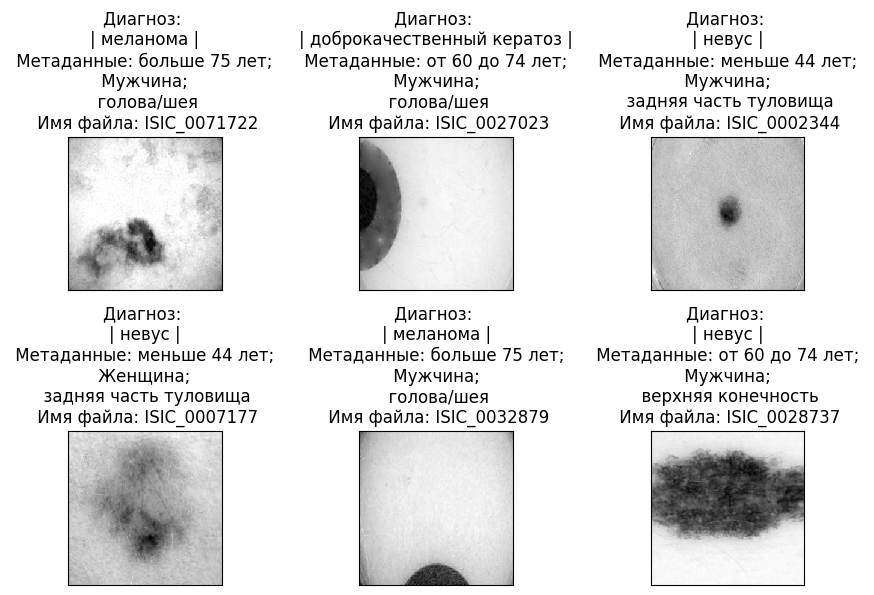

In [14]:
age = ['меньше 44 лет', 'от 45 до 59 лет', 'от 60 до 74 лет', 'больше 75 лет']
sex = ['Мужчина', 'Женщина']
anatomloc = ['торс', 'голова/шея', 'боковая часть туловища', 'нижняя конечность', 'оральная/генитальная зона', 'ладони/подошвы', 'задняя часть туловища', 'верхняя конечность']
lab = ['сосудистое поражение', 'невус', 'солнечное лентиго', 'дерматофиброма', 'себорейный кератоз', 'доброкачественный кератоз', 'актинический кератоз', 'базально-клеточная карцинома', 'плоскоклеточный рак', 'меланома']


examples = enumerate(trainloader)
batch_idx, (example_data, example_meta, example_targets, example_name) = next(examples)

plt.figure(1, figsize=[9,9])
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    age1 = example_meta[i][0].type(torch.LongTensor)
    sex1 = example_meta[i][1].type(torch.LongTensor)
    anatomloc1 = example_meta[i][2].type(torch.LongTensor)
    plt.title("Диагноз: \n| {} |\n Метаданные: {}; \n {}; \n  {} \n Имя файла: {}".format(lab[example_targets[i]], age[age1], sex[sex1], anatomloc[anatomloc1], example_name[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

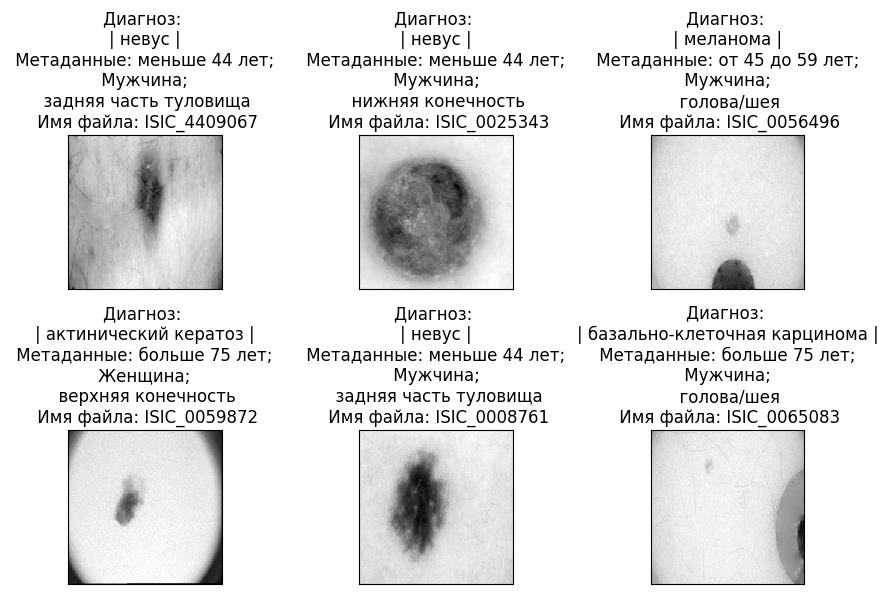

In [15]:
examples = enumerate(valloader)
batch_idx, (example_data, example_meta, example_targets, example_name) = next(examples)

plt.figure(1, figsize=[9,9])
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    age1 = example_meta[i][0].type(torch.LongTensor)
    sex1 = example_meta[i][1].type(torch.LongTensor)
    anatomloc1 = example_meta[i][2].type(torch.LongTensor)
    plt.title("Диагноз: \n| {} |\n Метаданные: {}; \n {}; \n  {} \n Имя файла: {}".format(lab[example_targets[i]], age[age1], sex[sex1], anatomloc[anatomloc1], example_name[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

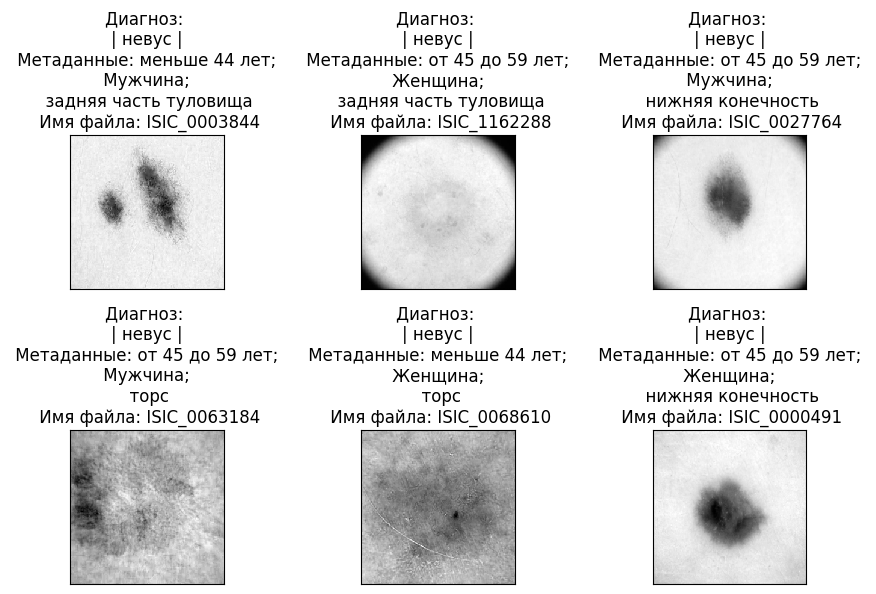

In [16]:
examples = enumerate(testloader)
batch_idx, (example_data, example_meta, example_targets, example_name) = next(examples)

plt.figure(1, figsize=[9,9])
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    age1 = example_meta[i][0].type(torch.LongTensor)
    sex1 = example_meta[i][1].type(torch.LongTensor)
    anatomloc1 = example_meta[i][2].type(torch.LongTensor)
    plt.title("Диагноз: \n| {} |\n Метаданные: {}; \n {}; \n  {} \n Имя файла: {}".format(lab[example_targets[i]], age[age1], sex[sex1], anatomloc[anatomloc1], example_name[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

In [17]:
def train_and_evaluate(model, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs, name_model):

    start_time_glob = time.time()
    model = model.to(device)
    model.train()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        model.train()
        start_time_tarin = time.time()
        
        print('_' * 120)
        print('Эпоха {}/{}\n'.format(epoch+1, num_epochs))
        
        running_loss = 0.0
        running_corrects = 0
        train_accuracy = 0
        total = 0
        correct_train = 0
        
        for i, data in enumerate(trainloader):
            inputs, feats, labels, name = data
            inputs, feats, labels = inputs.to(device), feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, feats)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            loss.backward() 
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            correct_train += preds.eq(labels.data.view_as(preds)).sum()

            total += labels.size(0)
            train_accuracy = 100 * running_corrects / total
            train_accuracy = train_accuracy.cpu()

            if i % 100 == 0:
                print('Тренировочная эпоха: {} [{}/{} ({:.0f}%)]\t\t | Ошибка: {:.4f}\t | Точность распознавания: {:.2f}%'.format(epoch+1, batch_size * i, len_trainset, 100 * i / len(trainloader), loss.item(), train_accuracy))
                
                train_counter.append((i*batch_size) + ((epoch)*len_trainset))
                train_losses.append(loss.item())
                train_acc.append(train_accuracy)
                
        epoch_loss = running_loss / len_trainset
        epoch_acc = running_corrects.double() / len_trainset
        
        time_tarin = time.time()-start_time_tarin
        
        print('\n   Тренировочная ошибка: {:.4f} Точность: {}/{} ({:.2f}%)'.format(epoch_loss, correct_train, len_trainset, 100 * epoch_acc))
        print ('        Время обучения: {}\n'.format(time.strftime("%H:%M:%S", time.gmtime(time_tarin))))
      
        model = model.to(device)
        model.eval()
        start_time_test = time.time()
        
        running_loss_val = 0.0 
        running_corrects_val = 0
        correct = 0
        
        with torch.no_grad():
            
            for data in valloader:
                
                inputs, feats, labels, name = data
                inputs, feats, labels = inputs.to(device), feats.to(device), labels.to(device)
            
                outputs = model(inputs, feats)
            
                loss = criterion(outputs,labels)
                _, preds = torch.max(outputs, 1)

                correct += preds.eq(labels.data.view_as(preds)).sum()
            
                running_loss_val += loss.item() * inputs.size(0)
                running_corrects_val += torch.sum(preds == labels.data)
        
            epoch_loss_val = running_loss_val / len_valset
            epoch_acc_val = running_corrects_val.double() / len_valset
            epoch_acc_val_2 = 100 * epoch_acc_val.cpu()

            test_losses.append(epoch_loss_val)
            test_acc.append(epoch_acc_val_2)

            time_test = time.time()-start_time_test

            scheduler.step(epoch_loss_val)
        
            if epoch_acc_val > best_acc:
                best_acc = epoch_acc_val
                best_model_wts = copy.deepcopy(model.state_dict())
            
                torch.save(model.state_dict(), f"BestModel_{model_name}_{name_model}.pth")

            print('   Валидационная ошибка: {:.4f} Точность: {}/{} ({:.2f}%)'.format(epoch_loss_val, correct, len_valset, 100 * epoch_acc_val))
            print ('        Время тестирования: {}\n'.format(time.strftime("%H:%M:%S", time.gmtime(time_test))))
        
            print('Лучшая валидационная точность: {:.4f}'.format(best_acc))

            #torch.save(model.state_dict(), f"{name_model}_epoch-{epoch+1}.pth")
            model.load_state_dict(best_model_wts)

    time_glob = time.time()-start_time_glob
    print('_' * 120)
    print ('\nОбщее время обучения: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time_glob))))
    
    return model

In [18]:
num_metadata_features = 3
num_classes = 10

fp32_model = Multimodal_NN(num_metadata_features, num_classes)
device = get_default_device()

# Замораживаем часть AlexNet для тонкой настройки
#for param in fp32_model.visual_features.parameters():
    #param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fp32_model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3)

num_epochs = 20

train_losses = []
train_counter = []
train_acc = []

test_losses = []
test_counter = [i*len_trainset for i in range(num_epochs)]
test_acc = []

fp32_model = train_and_evaluate(fp32_model, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs, 'fp32_model')

________________________________________________________________________________________________________________________
Эпоха 1/20

Тренировочная эпоха: 1 [0/25035 (0%)]		 | Ошибка: 2.2190	 | Точность распознавания: 32.81%
Тренировочная эпоха: 1 [6400/25035 (26%)]		 | Ошибка: 0.7826	 | Точность распознавания: 69.31%
Тренировочная эпоха: 1 [12800/25035 (51%)]		 | Ошибка: 0.5598	 | Точность распознавания: 72.72%
Тренировочная эпоха: 1 [19200/25035 (77%)]		 | Ошибка: 0.7201	 | Точность распознавания: 74.08%

   Тренировочная ошибка: 0.8167 Точность: 18763/25035 (74.95%)
        Время обучения: 00:00:16

   Валидационная ошибка: 0.6346 Точность: 6583/8345 (78.89%)
        Время тестирования: 00:00:04

Лучшая валидационная точность: 0.7889
________________________________________________________________________________________________________________________
Эпоха 2/20

Тренировочная эпоха: 2 [0/25035 (0%)]		 | Ошибка: 0.6338	 | Точность распознавания: 79.69%
Тренировочная эпоха: 2 [6400/2

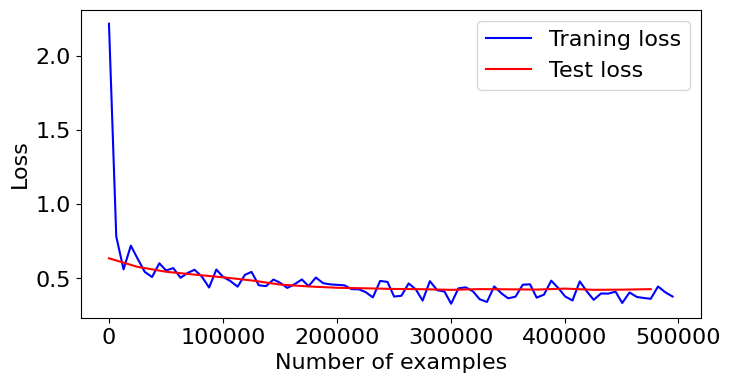

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=(8, 4))
plt.rcParams['font.size'] = '16'
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Traning loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
fig = plt.figure()
plt.show()

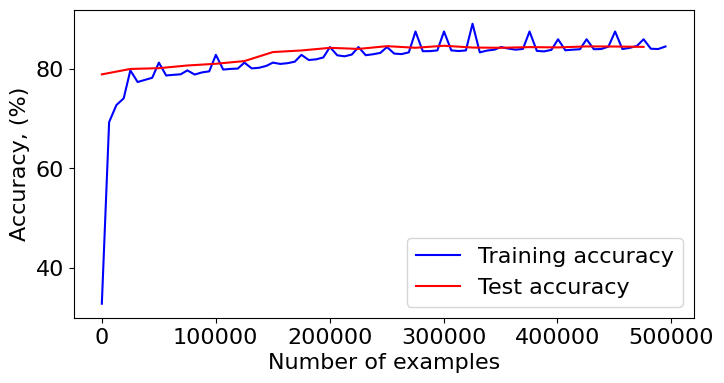

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(8, 4))
plt.rcParams['font.size'] = '16'
plt.plot(train_counter, train_acc, color='blue')
plt.plot(test_counter, test_acc, color='red')
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy, (%)')
fig = plt.figure()
plt.show()

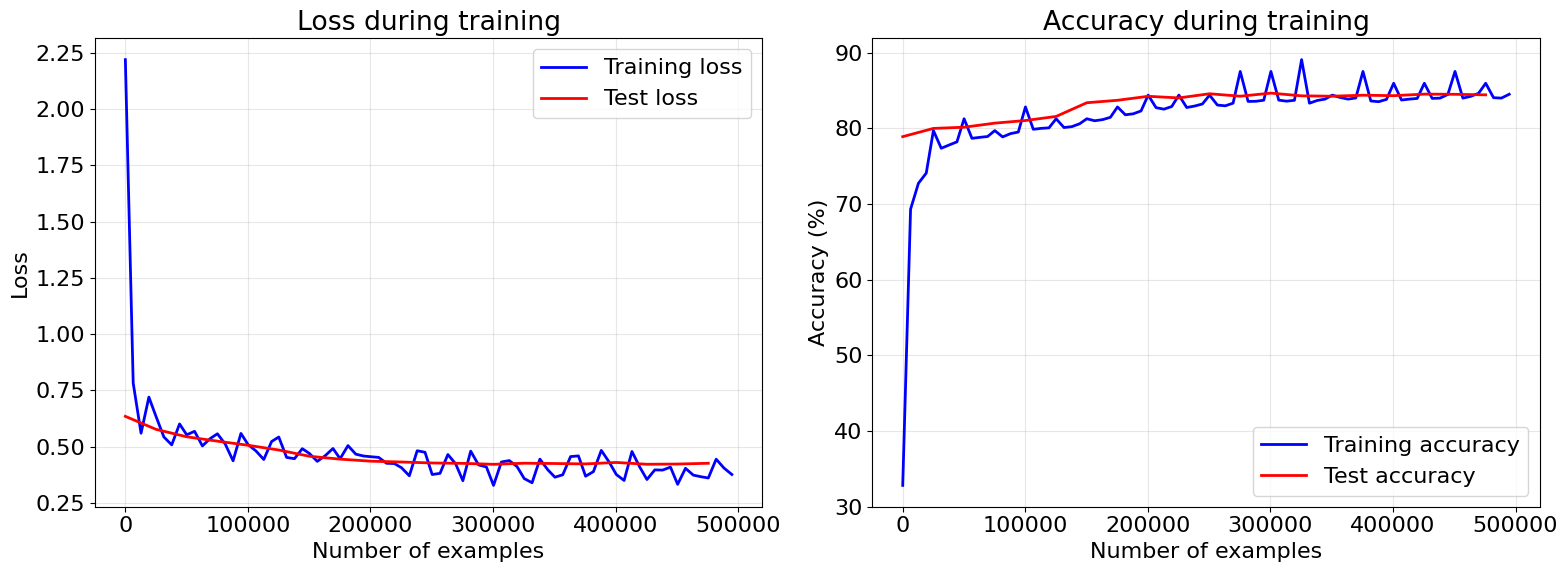

In [21]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.size'] = '16'

# Первый график - Loss
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
plt.plot(train_counter, train_losses, color='blue', linewidth=2)
plt.plot(test_counter, test_losses, color='red', linewidth=2)
plt.legend(['Training loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.grid(True, alpha=0.3)

# Второй график - Accuracy
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
plt.plot(train_counter, train_acc, color='blue', linewidth=2)
plt.plot(test_counter, test_acc, color='red', linewidth=2)
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Чтобы графики не перекрывались
plt.show()

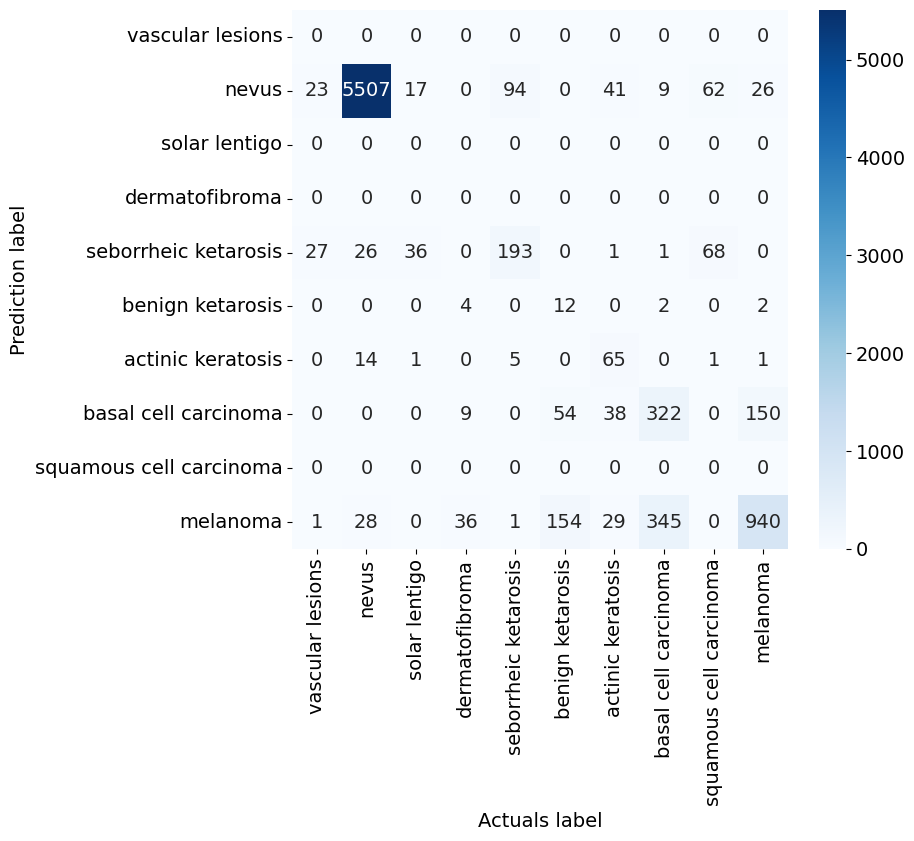

Sensitivity: 0.8435
Specificity: 0.9826
Precision: 0.8435
NPV: 0.9826
PPV: 0.8435
FNR: 0.1565
FPR: 0.0174
F1: 0.8435
Recall micro: 0.8435
Recall macro: 0.3389
Precision micro: 0.8435
Precision macro: 0.4023
F1 score micro: 0.8435
F1 score macro: 0.3390
Jaccard score micro: 0.7294
Jaccard score macro: 0.2648
Accuracy score: 0.8435
Matthews corrcoef: 0.6940
Specificity macro: 0.9763
Specificity micro: 0.9826
Specificity weighted: 0.9199
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.9018
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9803
Specificity none - class benign ketarosis (5): 0.9990
Specificity none - class actinic keratosis (6): 0.9973
Specificity none - class basal cell carcinoma (7): 0.9673
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9178


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
actuals = []
predictions = []

test_NN(fp32_model, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

fp32_final_acc = test_metric()

In [23]:
class QuantizedCNN(nn.Module):
    def __init__(self, original_alexnet):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.features = original_alexnet.features
        self.avgpool = original_alexnet.avgpool
        self.classifier = nn.Identity()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dequant(x)
        return x

def quantize_CNN_separately(model, calibration_loader):
    
    visual_classifier_state = model.visual_classifier.state_dict().copy()
    metadata_net_state = model.metadata_net.state_dict().copy()
    combined_classifier_state = model.combined_classifier.state_dict().copy()
    
    quantized_alexnet = QuantizedCNN(model.visual_features)
    quantized_alexnet = quantized_alexnet.to(device)
    quantized_alexnet.qconfig = get_default_qconfig('fbgemm')
    
    # Подготовка и калибровка
    model_prepared = prepare(quantized_alexnet, inplace=False)
    
    model_prepared.eval()
    with torch.no_grad():
        for i, data in enumerate(calibration_loader):
            images, metadata, label, name = data
            images, metadata = images.to(device), metadata.to(device)
            model_prepared(images)
            if i >= 50:
                break
    
    # Конвертация
    model_quantized_alexnet = convert(model_prepared, inplace=False)
    
    # Заменяем в основной модели
    model.visual_features = model_quantized_alexnet

    model.visual_classifier.load_state_dict(visual_classifier_state)
    model.metadata_net.load_state_dict(metadata_net_state)
    model.combined_classifier.load_state_dict(combined_classifier_state)
    
    return model

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

from torch.quantization import QuantStub, DeQuantStub, prepare, convert, get_default_qconfig

ptq_model_CNN = Multimodal_NN(num_metadata_features, num_classes).to(device)
ptq_model_CNN.load_state_dict(fp32_model.state_dict())

ptq_model_model_quantized_CNN = quantize_CNN_separately(ptq_model_CNN, trainloader)
print(f"PTQ мультимодальная модель ptq_model_model_quantized_CNN на int_8 успешно сконвертирована!")

#ptq_model_model_quantized_CNN

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


PTQ мультимодальная модель ptq_model_model_quantized_CNN на int_8 успешно сконвертирована!


In [24]:
def check_quantization_status(model):
    
    for name, module in model.named_modules():
        # Проверяем тип модуля
        module_type = type(module).__name__
        
        # Для обычных слоев
        if hasattr(module, 'weight') and not callable(module.weight):
            weight = module.weight
            print(f"{name}: {module_type} | dtype: {weight.dtype} | shape: {weight.shape}")
        
        # Для квантованных слоев
        elif hasattr(module, '_packed_params'):
            print(f"{name}: {module_type} | КВАНТОВАННЫЙ СЛОЙ")
        
        # Для QuantStub/DeQuantStub
        elif isinstance(module, (QuantStub, DeQuantStub)):
            print(f"{name}: {module_type}")

def get_model_size(model, model_name=""):
    torch.save(model.state_dict(), "temp_model.pth")

    size_bytes = os.path.getsize("temp_model.pth")
    size_mb = size_bytes / (1024 * 1024)

    os.remove("temp_model.pth")

    print("_" * 50)
    print(f"Размер {model_name}: {size_mb:.2f} МБ")
    return size_mb

def check_by_size_comparison_complete(original_model, quantized_model):
    print("ПОЛНОЕ СРАВНЕНИЕ КОМПОНЕНТОВ:")
    print("_" * 60)
    
    def get_component_size(component, name):
        torch.save(component.state_dict(), f"temp_{name}.pth")
        size_mb = os.path.getsize(f"temp_{name}.pth") / (1024 * 1024)
        os.remove(f"temp_{name}.pth")
        return size_mb
    
    total_orig_size = 0
    total_quant_size = 0
    
    # Компоненты для сравнения
    components_mapping = {
        'visual_features': 'CNN',
        'metadata_net': 'MLP', 
        'visual_classifier': 'CNN_classifier',
        'combined_classifier': 'Cat_classifier',
        'quantized_classifiers': 'Quant_classifiers'
    }
    
    print(f"{'Компонент':<25} {'Оригинал':<10} {'Квантован':<10} {'Сокращение':<12} Статус")
    print("_" * 60)
    
    # Основные компоненты
    main_components = ['visual_features', 'metadata_net', 'visual_classifier', 'combined_classifier']
    
    for comp in main_components:
        if hasattr(original_model, comp):
            orig_size = get_component_size(getattr(original_model, comp), f"orig_{comp}")
            total_orig_size += orig_size
            
            if hasattr(quantized_model, comp):
                quant_size = get_component_size(getattr(quantized_model, comp), f"quant_{comp}")
                total_quant_size += quant_size
                reduction = ((orig_size - quant_size) / orig_size) * 100
                status = "✅" if reduction > 10 else "⚪"
            else:
                quant_size = 0
                reduction = 100.0
                status = "🔄 ЗАМЕНЕН"
            
            print(f"{components_mapping.get(comp, comp):<25} {orig_size:>7.4f} МБ {quant_size:>7.4f} МБ {reduction:>9.2f}%   {status}")
    
    # Quantized classifiers (специальная обработка)
    if hasattr(quantized_model, 'quantized_classifiers'):
        # Размер квантованных классификаторов
        quant_size = get_component_size(quantized_model.quantized_classifiers, "quant_qc")
        total_quant_size += quant_size
        
        # Размер оригинальных классификаторов которые были заменены
        vc_size = get_component_size(original_model.visual_classifier, "orig_vc") if hasattr(original_model, 'visual_classifier') else 0
        cc_size = get_component_size(original_model.combined_classifier, "orig_cc") if hasattr(original_model, 'combined_classifier') else 0
        orig_combined_size = vc_size + cc_size
        
        reduction = ((orig_combined_size - quant_size) / orig_combined_size) * 100 if orig_combined_size > 0 else 0
        
        print(f"{'Quant_classifiers':<25} {orig_combined_size:>7.4f} МБ {quant_size:>7.4f} МБ {reduction:>9.2f}%   ✅")
    
    # Итоги
    total_reduction = ((total_orig_size - total_quant_size) / total_orig_size) * 100
    
    print("_" * 60)
    print(f"{'ОБЩИЙ РАЗМЕР':<25} {total_orig_size:>7.4f} МБ {total_quant_size:>7.4f} МБ {total_reduction:>9.2f}%   ")
    print("_" * 60)
    
    return total_orig_size, total_quant_size, total_reduction

check_quantization_status(ptq_model_model_quantized_CNN)
check_by_size_comparison_complete(fp32_model, ptq_model_model_quantized_CNN)

visual_features.features.0: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.3: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.6: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.8: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.10: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_classifier.1: Linear | dtype: torch.float32 | shape: torch.Size([512, 9216])
metadata_net.0: Linear | dtype: torch.float32 | shape: torch.Size([64, 3])
metadata_net.3: Linear | dtype: torch.float32 | shape: torch.Size([32, 64])
metadata_net.6: Linear | dtype: torch.float32 | shape: torch.Size([16, 32])
combined_classifier.0: Linear | dtype: torch.float32 | shape: torch.Size([128, 528])
combined_classifier.3: Linear | dtype: torch.float32 | shape: torch.Size([10, 128])
ПОЛНОЕ СРАВНЕНИЕ КОМПОНЕНТОВ:
____________________________________________________________
Компонент                 Оригинал   Квантован  Сокращение   Статус
____________________________________________________________
CNN                     

(27.708040237426758, 20.669227600097656, 25.403502293970952)

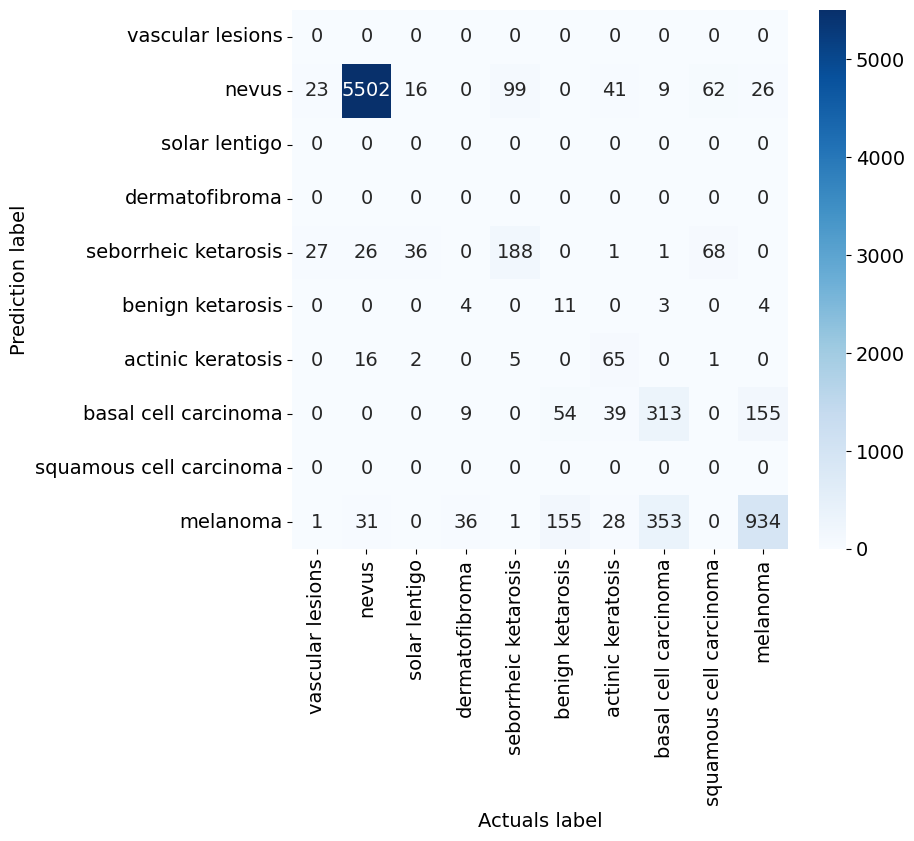

Sensitivity: 0.8404
Specificity: 0.9823
Precision: 0.8404
NPV: 0.9823
PPV: 0.8404
FNR: 0.1596
FPR: 0.0177
F1: 0.8404
Recall micro: 0.8404
Recall macro: 0.3348
Precision micro: 0.8404
Precision macro: 0.3880
F1 score micro: 0.8404
F1 score macro: 0.3346
Jaccard score micro: 0.7247
Jaccard score macro: 0.2608
Accuracy score: 0.8404
Matthews corrcoef: 0.6879
Specificity macro: 0.9759
Specificity micro: 0.9823
Specificity weighted: 0.9187
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.9004
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9803
Specificity none - class benign ketarosis (5): 0.9986
Specificity none - class actinic keratosis (6): 0.9971
Specificity none - class basal cell carcinoma (7): 0.9665
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9163


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(ptq_model_model_quantized_CNN, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

ptq_accuracy_CNN = test_metric()

In [26]:
class QuantizedMLP(nn.Module):
    def __init__(self, original_metadata_net):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.metadata_net = original_metadata_net
        
    def forward(self, x):
        x = self.quant(x)
        x = self.metadata_net(x)
        x = self.dequant(x)
        return x

def quantize_MLP_separately(model, calibration_loader):
    visual_features_state = model.visual_features.state_dict().copy()
    visual_classifier_state = model.visual_classifier.state_dict().copy()
    combined_classifier_state = model.combined_classifier.state_dict().copy()
    
    quantized_metadata_net = QuantizedMLP(model.metadata_net)
    quantized_metadata_net = quantized_metadata_net.to(device)
    quantized_metadata_net.qconfig = get_default_qconfig('fbgemm')

    model_prepared = prepare(quantized_metadata_net, inplace=False)

    model_prepared.eval()
    with torch.no_grad():
        for i, data in enumerate(calibration_loader):
            images, metadata, label, name = data
            images, metadata = images.to(device), metadata.to(device)
            model_prepared(metadata)
            if i >= 50:
                break

    model_quantized_metadata_net = convert(model_prepared, inplace=False)

    model.metadata_net = model_quantized_metadata_net

    model.visual_features.load_state_dict(visual_features_state)
    model.visual_classifier.load_state_dict(visual_classifier_state)
    model.combined_classifier.load_state_dict(combined_classifier_state)

    return model

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

ptq_model_MLP = Multimodal_NN(num_metadata_features, num_classes).to(device)
ptq_model_MLP.load_state_dict(fp32_model.state_dict())

ptq_model_model_quantized_MLP = quantize_MLP_separately(ptq_model_MLP, trainloader)
print(f"PTQ мультимодальная модель ptq_model_model_quantized_MLP на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


PTQ мультимодальная модель ptq_model_model_quantized_MLP на int_8 успешно сконвертирована!


In [27]:
check_quantization_status(ptq_model_model_quantized_MLP)
check_by_size_comparison_complete(fp32_model, ptq_model_model_quantized_MLP)

visual_features.features.0: Conv2d | dtype: torch.float32 | shape: torch.Size([64, 3, 11, 11])
visual_features.features.3: Conv2d | dtype: torch.float32 | shape: torch.Size([192, 64, 5, 5])
visual_features.features.6: Conv2d | dtype: torch.float32 | shape: torch.Size([384, 192, 3, 3])
visual_features.features.8: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 384, 3, 3])
visual_features.features.10: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 256, 3, 3])
visual_classifier.1: Linear | dtype: torch.float32 | shape: torch.Size([512, 9216])
metadata_net.metadata_net.0: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.0._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.3: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.3._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.6: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.6._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.

(27.708040237426758, 27.70623207092285, 0.006525782727368285)

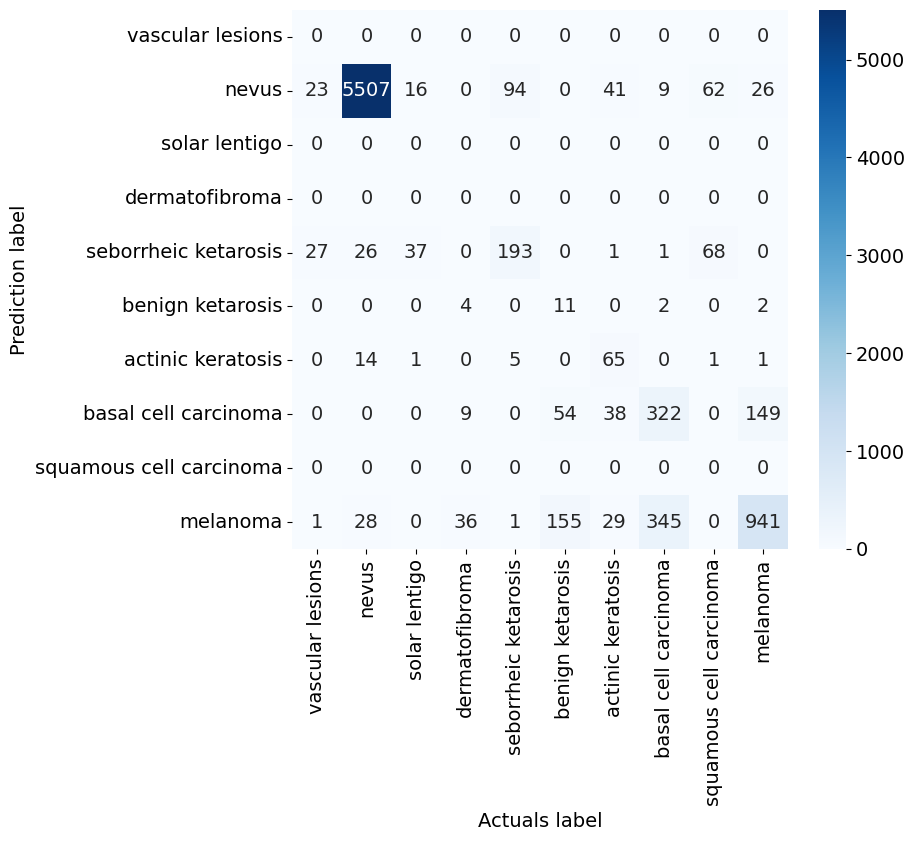

Sensitivity: 0.8435
Specificity: 0.9826
Precision: 0.8435
NPV: 0.9826
PPV: 0.8435
FNR: 0.1565
FPR: 0.0174
F1: 0.8435
Recall micro: 0.8435
Recall macro: 0.3385
Precision micro: 0.8435
Precision macro: 0.4001
F1 score micro: 0.8435
F1 score macro: 0.3381
Jaccard score micro: 0.7294
Jaccard score macro: 0.2644
Accuracy score: 0.8435
Matthews corrcoef: 0.6941
Specificity macro: 0.9764
Specificity micro: 0.9826
Specificity weighted: 0.9202
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.9022
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9801
Specificity none - class benign ketarosis (5): 0.9990
Specificity none - class actinic keratosis (6): 0.9973
Specificity none - class basal cell carcinoma (7): 0.9674
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9177


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(ptq_model_model_quantized_MLP, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

ptq_accuracy_MLP = test_metric()

In [29]:
class QuantizedClassifiers(nn.Module):
    def __init__(self, original_visual_classifier, original_combined_classifier):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.visual_classifier = original_visual_classifier
        self.combined_classifier = original_combined_classifier
        
    def forward(self, visual_features, metadata_features):
        visual_features = self.quant(visual_features)
        visual_out = self.visual_classifier(visual_features)
        visual_out = self.dequant(visual_out)
        
        combined_features = torch.cat((visual_out, metadata_features), dim=1)
        
        combined_features = self.quant(combined_features)
        output = self.combined_classifier(combined_features)
        output = self.dequant(output)
        
        return output

def quantize_classifiers_together(model, calibration_loader):
    visual_features_state = model.visual_features.state_dict().copy()
    metadata_net_state = model.metadata_net.state_dict().copy()
    
    quantized_classifiers = QuantizedClassifiers(
        model.visual_classifier, 
        model.combined_classifier
    )
    quantized_classifiers = quantized_classifiers.to(device)
    quantized_classifiers.qconfig = get_default_qconfig('fbgemm')

    model_prepared = prepare(quantized_classifiers, inplace=False)

    model_prepared.eval()
    with torch.no_grad():
        for i, data in enumerate(calibration_loader):
            images, metadata, label, name = data
            images, metadata = images.to(device), metadata.to(device)

            with torch.no_grad():
                visual_features = model.visual_features(images)
                visual_features = visual_features.reshape(visual_features.size(0), -1)

                metadata_features = model.metadata_net(metadata)

            model_prepared(visual_features, metadata_features)
            if i >= 50:
                break

    model_quantized_classifiers = convert(model_prepared, inplace=False)
    

    class Multimodal_With_QuantizedClassifiers(nn.Module):
        def __init__(self, visual_features, metadata_net, quantized_classifiers):
            super().__init__()
            self.visual_features = visual_features
            self.metadata_net = metadata_net
            self.quantized_classifiers = quantized_classifiers
            
        def forward(self, image, metadata):
            visual_features = self.visual_features(image)
            visual_features = visual_features.reshape(visual_features.size(0), -1)
            
            metadata_features = self.metadata_net(metadata)

            output = self.quantized_classifiers(visual_features, metadata_features)
            return output

    final_model = Multimodal_With_QuantizedClassifiers(
        model.visual_features,
        model.metadata_net, 
        model_quantized_classifiers
    )

    final_model.visual_features.load_state_dict(visual_features_state)
    final_model.metadata_net.load_state_dict(metadata_net_state)

    return final_model

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

ptq_model_linear = Multimodal_NN(num_metadata_features, num_classes).to(device)
ptq_model_linear.load_state_dict(fp32_model.state_dict())

ptq_model_model_quantized_linear = quantize_classifiers_together(ptq_model_linear, trainloader)
print(f"PTQ мультимодальная модель ptq_model_model_quantized_linear на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


PTQ мультимодальная модель ptq_model_model_quantized_linear на int_8 успешно сконвертирована!


In [30]:
check_quantization_status(ptq_model_model_quantized_linear)
check_by_size_comparison_complete(fp32_model, ptq_model_model_quantized_linear)

visual_features.features.0: Conv2d | dtype: torch.float32 | shape: torch.Size([64, 3, 11, 11])
visual_features.features.3: Conv2d | dtype: torch.float32 | shape: torch.Size([192, 64, 5, 5])
visual_features.features.6: Conv2d | dtype: torch.float32 | shape: torch.Size([384, 192, 3, 3])
visual_features.features.8: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 384, 3, 3])
visual_features.features.10: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 256, 3, 3])
metadata_net.0: Linear | dtype: torch.float32 | shape: torch.Size([64, 3])
metadata_net.3: Linear | dtype: torch.float32 | shape: torch.Size([32, 64])
metadata_net.6: Linear | dtype: torch.float32 | shape: torch.Size([16, 32])
quantized_classifiers.visual_classifier.1: Linear | КВАНТОВАННЫЙ СЛОЙ
quantized_classifiers.visual_classifier.1._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
quantized_classifiers.combined_classifier.0: Linear | КВАНТОВАННЫЙ СЛОЙ
quantized_classifiers.combined_classifier.0._packed_par

(27.708040237426758, 14.023883819580078, 49.386951587296835)

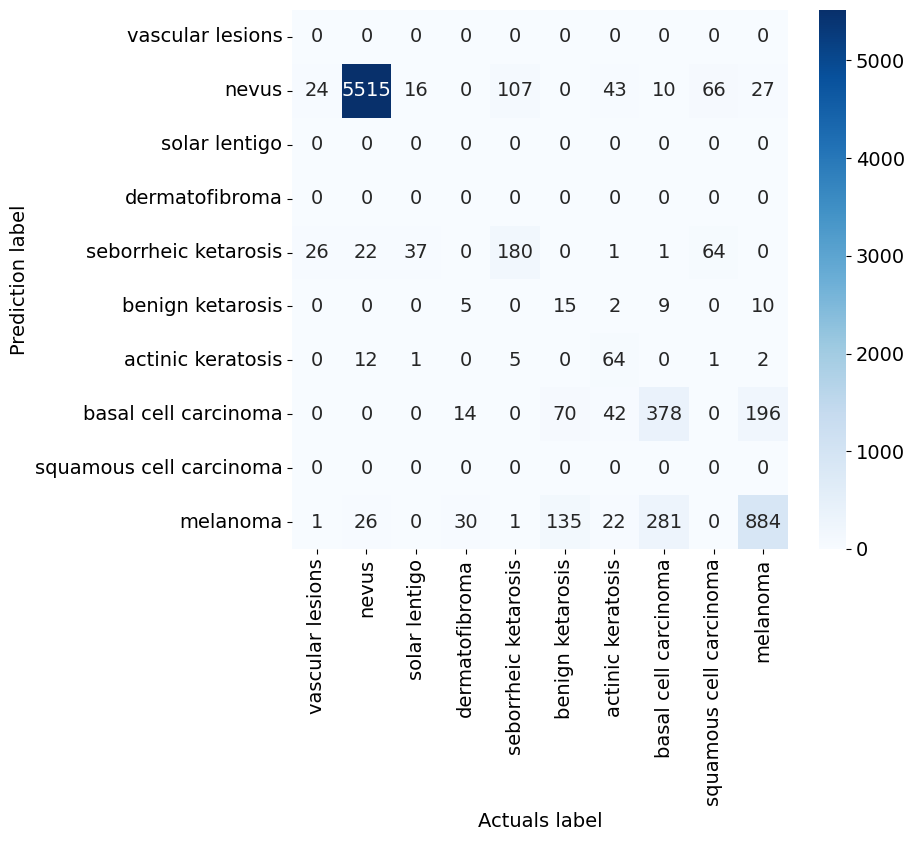

Sensitivity: 0.8431
Specificity: 0.9826
Precision: 0.8431
NPV: 0.9826
PPV: 0.8431
FNR: 0.1569
FPR: 0.0174
F1: 0.8431
Recall micro: 0.8431
Recall macro: 0.3386
Precision micro: 0.8431
Precision macro: 0.3793
F1 score micro: 0.8431
F1 score macro: 0.3411
Jaccard score micro: 0.7288
Jaccard score macro: 0.2659
Accuracy score: 0.8431
Matthews corrcoef: 0.6916
Specificity macro: 0.9759
Specificity micro: 0.9826
Specificity weighted: 0.9159
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.8942
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9812
Specificity none - class benign ketarosis (5): 0.9968
Specificity none - class actinic keratosis (6): 0.9974
Specificity none - class basal cell carcinoma (7): 0.9580
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9314


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(ptq_model_model_quantized_linear, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

ptq_accuracy_linear = test_metric()

In [32]:
class QuantizedMultimodal(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.visual_features = original_model.visual_features
        self.visual_classifier = original_model.visual_classifier
        self.metadata_net = original_model.metadata_net
        self.combined_classifier = original_model.combined_classifier
        
    def forward(self, image, metadata):
        image = self.quant(image)
        metadata = self.quant(metadata)

        visual_feat = self.visual_features(image)
        visual_feat = visual_feat.view(visual_feat.size(0), -1)
        visual_out = self.visual_classifier(visual_feat)
        
        metadata_out = self.metadata_net(metadata)

        visual_out = self.dequant(visual_out)
        metadata_out = self.dequant(metadata_out)
        
        combined = torch.cat((visual_out, metadata_out), dim=1)

        combined = self.quant(combined)
        output = self.combined_classifier(combined)
        output = self.dequant(output)
        
        return output

def quantize_completely_simple(model, calibration_loader):
    
    quant_model = QuantizedMultimodal(model)
    quant_model = quant_model.to(device)

    quant_model.qconfig = get_default_qconfig('fbgemm')

    model_prepared = prepare(quant_model, inplace=False)
   
    print("Калибровка...")
    model_prepared.eval()
    with torch.no_grad():
        for i, (images, metadata, _, _) in enumerate(calibration_loader):
            images, metadata = images.to(device), metadata.to(device)
            model_prepared(images, metadata)
            if i >= 30:
                break
                
    model_quantized = convert(model_prepared, inplace=False)
    
    return model_quantized

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

ptq_model_full = Multimodal_NN(num_metadata_features, num_classes).to(device)
ptq_model_full.load_state_dict(fp32_model.state_dict())

ptq_model_model_quantized_full = quantize_completely_simple(ptq_model_full, trainloader)
print(f"PTQ мультимодальная модель на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Калибровка...
PTQ мультимодальная модель на int_8 успешно сконвертирована!


In [33]:
check_quantization_status(ptq_model_model_quantized_full)
check_by_size_comparison_complete(fp32_model, ptq_model_model_quantized_full)

visual_features.features.0: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.3: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.6: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.8: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.10: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_classifier.1: Linear | КВАНТОВАННЫЙ СЛОЙ
visual_classifier.1._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.0: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.0._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.3: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.3._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.6: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.6._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.0: Linear | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.0._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.3: Linear | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.3._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
ПОЛНОЕ С

(27.708040237426758, 6.982297897338867, 74.80046283494457)

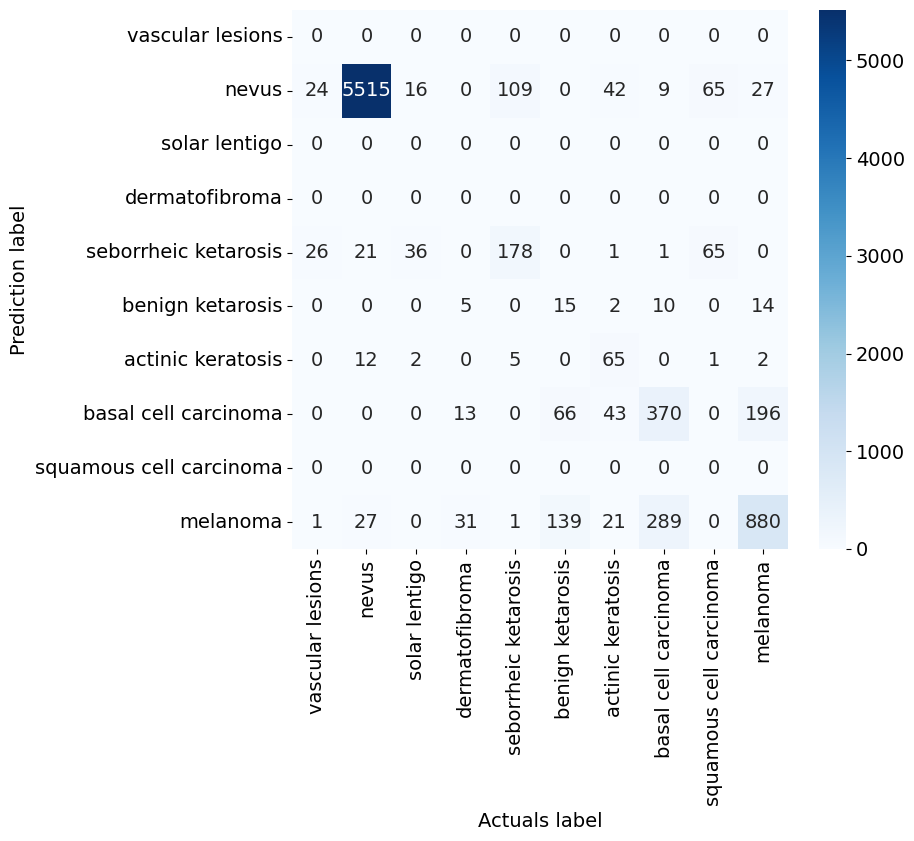

Sensitivity: 0.8416
Specificity: 0.9824
Precision: 0.8416
NPV: 0.9824
PPV: 0.8416
FNR: 0.1584
FPR: 0.0176
F1: 0.8416
Recall micro: 0.8416
Recall macro: 0.3370
Precision micro: 0.8416
Precision macro: 0.3737
F1 score micro: 0.8416
F1 score macro: 0.3396
Jaccard score micro: 0.7265
Jaccard score macro: 0.2645
Accuracy score: 0.8416
Matthews corrcoef: 0.6885
Specificity macro: 0.9758
Specificity micro: 0.9824
Specificity weighted: 0.9159
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.8946
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9814
Specificity none - class benign ketarosis (5): 0.9962
Specificity none - class actinic keratosis (6): 0.9973
Specificity none - class basal cell carcinoma (7): 0.9585
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9296


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(ptq_model_model_quantized_full, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

ptq_accuracy_full = test_metric()

In [35]:
class QuantizedCNN_QAT(nn.Module):
    def __init__(self, original_alexnet):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.features = original_alexnet.features
        self.avgpool = original_alexnet.avgpool
        self.classifier = nn.Identity()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dequant(x)
        return x

def QAT_quantize_CNN_separately(model):
    
    visual_classifier_state = model.visual_classifier.state_dict().copy()
    metadata_net_state = model.metadata_net.state_dict().copy()
    combined_classifier_state = model.combined_classifier.state_dict().copy()
    
    quantized_alexnet = QuantizedCNN_QAT(model.visual_features)

    device = torch.device("cpu")
    quantized_alexnet = quantized_alexnet.to(device)
    quantized_alexnet.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    
    # Подготовка
    model_prepared = prepare_qat(quantized_alexnet, inplace=False)
    
    # Заменяем в основной модели
    model.visual_features = model_prepared

    model.visual_classifier.load_state_dict(visual_classifier_state)
    model.metadata_net.load_state_dict(metadata_net_state)
    model.combined_classifier.load_state_dict(combined_classifier_state)
    return model

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

qat_model_CNN = Multimodal_NN(num_metadata_features, num_classes).to(device)
qat_model_CNN.load_state_dict(fp32_model.state_dict())

qat_model_CNN = QAT_quantize_CNN_separately(qat_model_CNN)

print("Начало QAT с предобученными весами...")
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(qat_model_CNN.parameters(), lr=0.001, momentum=0.9)
    
num_epochs = 5
    
train_losses = []
train_counter = []
train_acc = []
    
test_losses = []
test_counter = [i*len_trainset for i in range(num_epochs)]
test_acc = []
    
device = torch.device("cuda")
qat_model_CNN  = train_and_evaluate(qat_model_CNN, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs, 'qat_model_CNN')

device = torch.device("cpu")
qat_model_CNN .eval()
qat_model_CNN  = qat_model_CNN.to(device)
qat_model_CNN.visual_features = convert(qat_model_CNN.visual_features, inplace=False)

print(f"QAT мультимодальная модель qat_model_CNN на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Начало QAT с предобученными весами...
________________________________________________________________________________________________________________________
Эпоха 1/5

Тренировочная эпоха: 1 [0/25035 (0%)]		 | Ошибка: 0.3680	 | Точность распознавания: 82.81%
Тренировочная эпоха: 1 [6400/25035 (26%)]		 | Ошибка: 0.4596	 | Точность распознавания: 83.74%
Тренировочная эпоха: 1 [12800/25035 (51%)]		 | Ошибка: 0.4239	 | Точность распознавания: 83.69%
Тренировочная эпоха: 1 [19200/25035 (77%)]		 | Ошибка: 0.4188	 | Точность распознавания: 83.98%

   Тренировочная ошибка: 0.4231 Точность: 21109/25035 (84.32%)
        Время обучения: 00:00:18

   Валидационная ошибка: 0.4205 Точность: 7053/8345 (84.52%)
        Время тестирования: 00:00:04

Лучшая валидационная точность: 0.8452
________________________________________________________________________________________________________________________
Эпоха 2/5

Тренировочная эпоха: 2 [0/25035 (0%)]		 | Ошибка: 0.3944	 | Точность распознавания: 8

In [36]:
check_quantization_status(qat_model_CNN)
check_by_size_comparison_complete(fp32_model, qat_model_CNN)

visual_features.features.0: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.3: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.6: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.8: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.10: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_classifier.1: Linear | dtype: torch.float32 | shape: torch.Size([512, 9216])
metadata_net.0: Linear | dtype: torch.float32 | shape: torch.Size([64, 3])
metadata_net.3: Linear | dtype: torch.float32 | shape: torch.Size([32, 64])
metadata_net.6: Linear | dtype: torch.float32 | shape: torch.Size([16, 32])
combined_classifier.0: Linear | dtype: torch.float32 | shape: torch.Size([128, 528])
combined_classifier.3: Linear | dtype: torch.float32 | shape: torch.Size([10, 128])
ПОЛНОЕ СРАВНЕНИЕ КОМПОНЕНТОВ:
____________________________________________________________
Компонент                 Оригинал   Квантован  Сокращение   Статус
____________________________________________________________
CNN                     

(27.708040237426758, 20.669227600097656, 25.403502293970952)

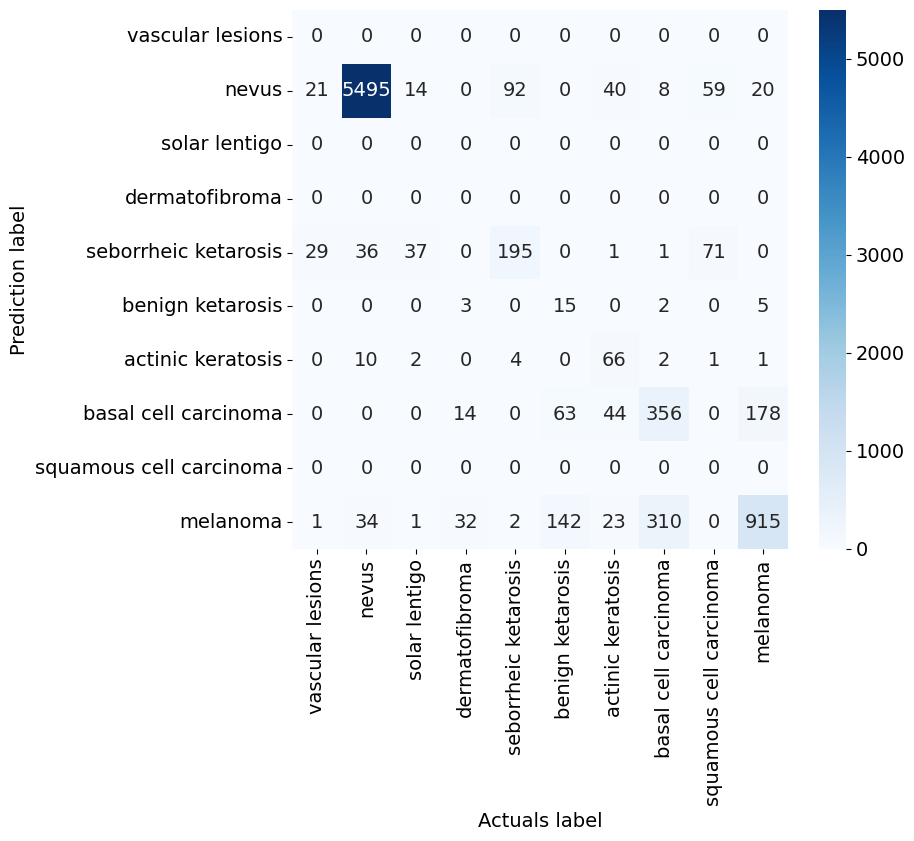

Sensitivity: 0.8439
Specificity: 0.9827
Precision: 0.8439
NPV: 0.9827
PPV: 0.8439
FNR: 0.1561
FPR: 0.0173
F1: 0.8439
Recall micro: 0.8439
Recall macro: 0.3441
Precision micro: 0.8439
Precision macro: 0.4021
F1 score micro: 0.8439
F1 score macro: 0.3432
Jaccard score micro: 0.7299
Jaccard score macro: 0.2679
Accuracy score: 0.8439
Matthews corrcoef: 0.6954
Specificity macro: 0.9768
Specificity micro: 0.9827
Specificity weighted: 0.9246
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.9083
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9783
Specificity none - class benign ketarosis (5): 0.9988
Specificity none - class actinic keratosis (6): 0.9976
Specificity none - class basal cell carcinoma (7): 0.9610
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9246


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(qat_model_CNN, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

qat_accuracy_CNN = test_metric()

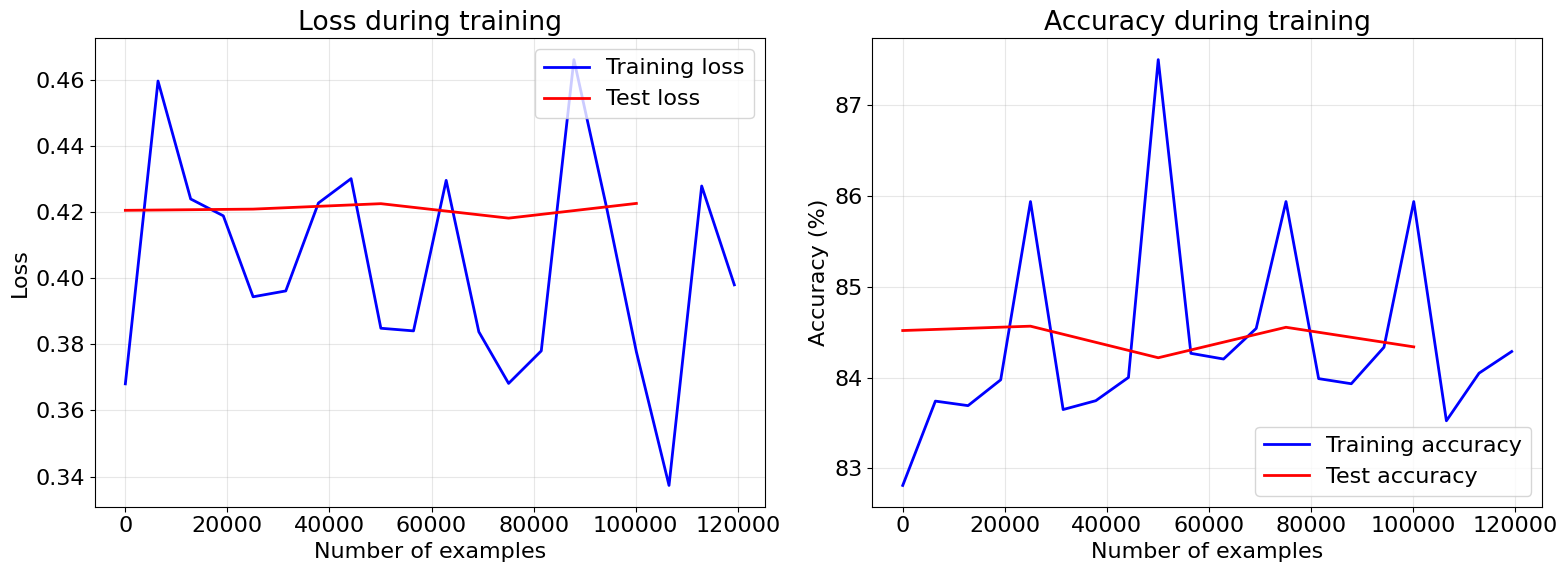

In [38]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.size'] = '16'

# Первый график - Loss
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
plt.plot(train_counter, train_losses, color='blue', linewidth=2)
plt.plot(test_counter, test_losses, color='red', linewidth=2)
plt.legend(['Training loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.grid(True, alpha=0.3)

# Второй график - Accuracy
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
plt.plot(train_counter, train_acc, color='blue', linewidth=2)
plt.plot(test_counter, test_acc, color='red', linewidth=2)
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Чтобы графики не перекрывались
plt.show()

In [39]:
class QuantizedMLP_QAT(nn.Module):
    def __init__(self, original_metadata_net):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.metadata_net = original_metadata_net
        
    def forward(self, x):
        x = self.quant(x)
        x = self.metadata_net(x)
        x = self.dequant(x)
        return x

def QAT_quantize_MLP_separately(model):
    visual_features_state = model.visual_features.state_dict().copy()
    visual_classifier_state = model.visual_classifier.state_dict().copy()
    combined_classifier_state = model.combined_classifier.state_dict().copy()
    
    quantized_metadata_net = QuantizedMLP_QAT(model.metadata_net)
    quantized_metadata_net = quantized_metadata_net.to(device)
    quantized_metadata_net.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

    model_prepared = prepare_qat(quantized_metadata_net, inplace=False)

    model.metadata_net = model_prepared

    model.visual_features.load_state_dict(visual_features_state)
    model.visual_classifier.load_state_dict(visual_classifier_state)
    model.combined_classifier.load_state_dict(combined_classifier_state)

    return model

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

qat_model_MLP = Multimodal_NN(num_metadata_features, num_classes).to(device)
qat_model_MLP.load_state_dict(fp32_model.state_dict())

qat_model_MLP = QAT_quantize_MLP_separately(qat_model_MLP)

print("Начало QAT с предобученными весами...")
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(qat_model_MLP.parameters(), lr=0.001, momentum=0.9)
    
num_epochs = 5
    
train_losses = []
train_counter = []
train_acc = []
    
test_losses = []
test_counter = [i*len_trainset for i in range(num_epochs)]
test_acc = []
    
device = torch.device("cuda")
qat_model_MLP  = train_and_evaluate(qat_model_MLP, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs, 'qat_model_MLP')

device = torch.device("cpu")
qat_model_MLP .eval()
qat_model_MLP  = qat_model_MLP.to(device)
qat_model_MLP.metadata_net = convert(qat_model_MLP.metadata_net, inplace=False)

print(f"QAT мультимодальная модель qat_model_MLP на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Начало QAT с предобученными весами...
________________________________________________________________________________________________________________________
Эпоха 1/5

Тренировочная эпоха: 1 [0/25035 (0%)]		 | Ошибка: 0.3745	 | Точность распознавания: 89.06%
Тренировочная эпоха: 1 [6400/25035 (26%)]		 | Ошибка: 0.4296	 | Точность распознавания: 83.38%
Тренировочная эпоха: 1 [12800/25035 (51%)]		 | Ошибка: 0.4459	 | Точность распознавания: 83.54%
Тренировочная эпоха: 1 [19200/25035 (77%)]		 | Ошибка: 0.4163	 | Точность распознавания: 83.86%

   Тренировочная ошибка: 0.4261 Точность: 21066/25035 (84.15%)
        Время обучения: 00:00:17

   Валидационная ошибка: 0.4233 Точность: 7038/8345 (84.34%)
        Время тестирования: 00:00:04

Лучшая валидационная точность: 0.8434
________________________________________________________________________________________________________________________
Эпоха 2/5

Тренировочная эпоха: 2 [0/25035 (0%)]		 | Ошибка: 0.3770	 | Точность распознавания: 8

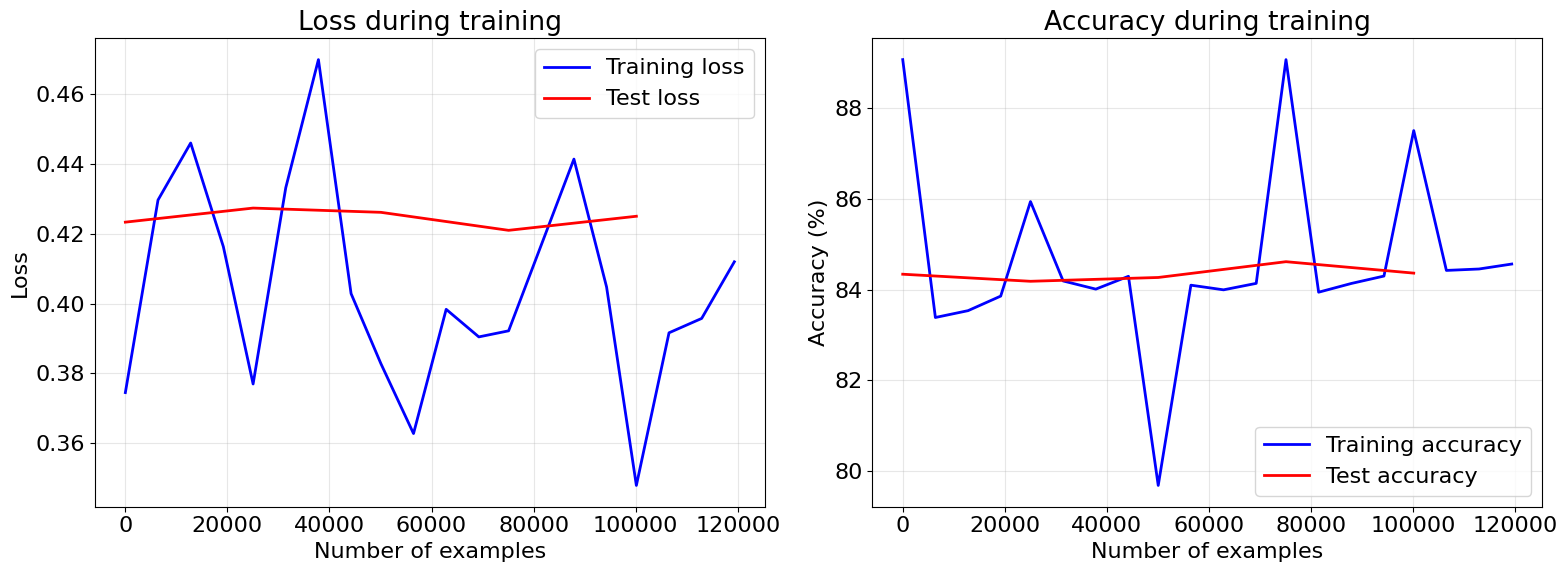

In [40]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.size'] = '16'

# Первый график - Loss
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
plt.plot(train_counter, train_losses, color='blue', linewidth=2)
plt.plot(test_counter, test_losses, color='red', linewidth=2)
plt.legend(['Training loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.grid(True, alpha=0.3)

# Второй график - Accuracy
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
plt.plot(train_counter, train_acc, color='blue', linewidth=2)
plt.plot(test_counter, test_acc, color='red', linewidth=2)
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Чтобы графики не перекрывались
plt.show()

In [41]:
check_quantization_status(qat_model_MLP)
check_by_size_comparison_complete(fp32_model, qat_model_MLP)

visual_features.features.0: Conv2d | dtype: torch.float32 | shape: torch.Size([64, 3, 11, 11])
visual_features.features.3: Conv2d | dtype: torch.float32 | shape: torch.Size([192, 64, 5, 5])
visual_features.features.6: Conv2d | dtype: torch.float32 | shape: torch.Size([384, 192, 3, 3])
visual_features.features.8: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 384, 3, 3])
visual_features.features.10: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 256, 3, 3])
visual_classifier.1: Linear | dtype: torch.float32 | shape: torch.Size([512, 9216])
metadata_net.metadata_net.0: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.0._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.3: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.3._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.6: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.metadata_net.6._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.

(27.708040237426758, 27.70623207092285, 0.006525782727368285)

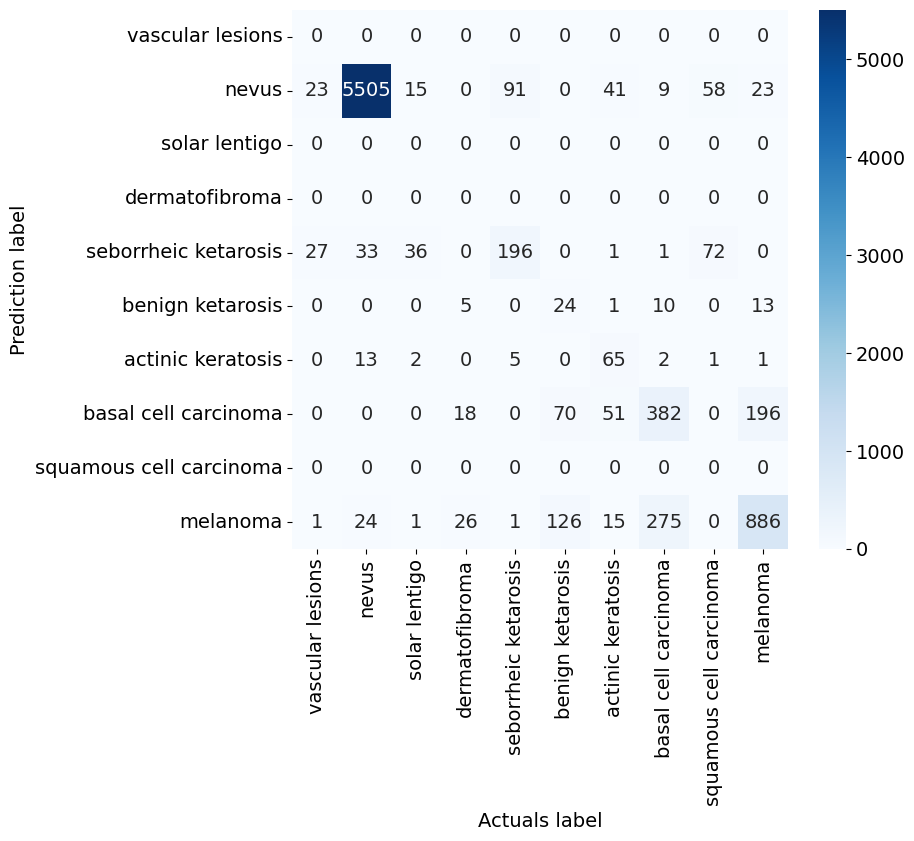

Sensitivity: 0.8458
Specificity: 0.9829
Precision: 0.8458
NPV: 0.9829
PPV: 0.8458
FNR: 0.1542
FPR: 0.0171
F1: 0.8458
Recall micro: 0.8458
Recall macro: 0.3493
Precision micro: 0.8458
Precision macro: 0.3860
F1 score micro: 0.8458
F1 score macro: 0.3499
Jaccard score micro: 0.7328
Jaccard score macro: 0.2726
Accuracy score: 0.8458
Matthews corrcoef: 0.6984
Specificity macro: 0.9770
Specificity micro: 0.9829
Specificity weighted: 0.9241
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.9061
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9789
Specificity none - class benign ketarosis (5): 0.9964
Specificity none - class actinic keratosis (6): 0.9971
Specificity none - class basal cell carcinoma (7): 0.9563
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9351


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(qat_model_MLP, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

qat_accuracy_MLP = test_metric()

In [43]:
class QuantizedClassifiers_QAT(nn.Module):
    def __init__(self, original_visual_classifier, original_combined_classifier):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.visual_classifier = original_visual_classifier
        self.combined_classifier = original_combined_classifier
        
    def forward(self, visual_features, metadata_features):
        visual_features = self.quant(visual_features)
        visual_out = self.visual_classifier(visual_features)
        visual_out = self.dequant(visual_out)
        
        combined_features = torch.cat((visual_out, metadata_features), dim=1)
        
        combined_features = self.quant(combined_features)
        output = self.combined_classifier(combined_features)
        output = self.dequant(output)
        
        return output

def QAT_quantize_classifiers_together(model):
    visual_features_state = model.visual_features.state_dict().copy()
    metadata_net_state = model.metadata_net.state_dict().copy()
    
    quantized_classifiers = QuantizedClassifiers_QAT(
        model.visual_classifier, 
        model.combined_classifier
    )
    quantized_classifiers = quantized_classifiers.to(device)
    quantized_classifiers.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

    model_prepared = prepare_qat(quantized_classifiers, inplace=False)
    

    class Multimodal_With_QuantizedClassifiers_QAT(nn.Module):
        def __init__(self, visual_features, metadata_net, quantized_classifiers):
            super().__init__()
            self.visual_features = visual_features
            self.metadata_net = metadata_net
            self.quantized_classifiers = quantized_classifiers
            
        def forward(self, image, metadata):
            visual_features = self.visual_features(image)
            visual_features = visual_features.reshape(visual_features.size(0), -1)
            
            metadata_features = self.metadata_net(metadata)

            output = self.quantized_classifiers(visual_features, metadata_features)
            return output

    final_model = Multimodal_With_QuantizedClassifiers_QAT(
        model.visual_features,
        model.metadata_net, 
        model_prepared
    )

    final_model.visual_features.load_state_dict(visual_features_state)
    final_model.metadata_net.load_state_dict(metadata_net_state)

    return final_model

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

qat_model_classifier = Multimodal_NN(num_metadata_features, num_classes).to(device)
qat_model_classifier.load_state_dict(fp32_model.state_dict())

qat_model_classifier = QAT_quantize_classifiers_together(qat_model_classifier)

print("Начало QAT с предобученными весами...")
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(qat_model_classifier.parameters(), lr=0.001, momentum=0.9)
    
num_epochs = 5
    
train_losses = []
train_counter = []
train_acc = []
    
test_losses = []
test_counter = [i*len_trainset for i in range(num_epochs)]
test_acc = []
    
device = torch.device("cuda")
qat_model_classifier  = train_and_evaluate(qat_model_classifier, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs, 'qat_model_classifier')

device = torch.device("cpu")
qat_model_classifier .eval()
qat_model_classifier  = qat_model_classifier.to(device)
qat_model_classifier.quantized_classifiers = convert(qat_model_classifier.quantized_classifiers, inplace=False)

print(f"QAT мультимодальная модель qat_model_classifier на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Начало QAT с предобученными весами...
________________________________________________________________________________________________________________________
Эпоха 1/5

Тренировочная эпоха: 1 [0/25035 (0%)]		 | Ошибка: 0.3742	 | Точность распознавания: 84.38%
Тренировочная эпоха: 1 [6400/25035 (26%)]		 | Ошибка: 0.4311	 | Точность распознавания: 83.90%
Тренировочная эпоха: 1 [12800/25035 (51%)]		 | Ошибка: 0.4276	 | Точность распознавания: 83.85%
Тренировочная эпоха: 1 [19200/25035 (77%)]		 | Ошибка: 0.4050	 | Точность распознавания: 84.06%

   Тренировочная ошибка: 0.4211 Точность: 21076/25035 (84.19%)
        Время обучения: 00:00:17

   Валидационная ошибка: 0.4228 Точность: 7057/8345 (84.57%)
        Время тестирования: 00:00:04

Лучшая валидационная точность: 0.8457
________________________________________________________________________________________________________________________
Эпоха 2/5

Тренировочная эпоха: 2 [0/25035 (0%)]		 | Ошибка: 0.3762	 | Точность распознавания: 8

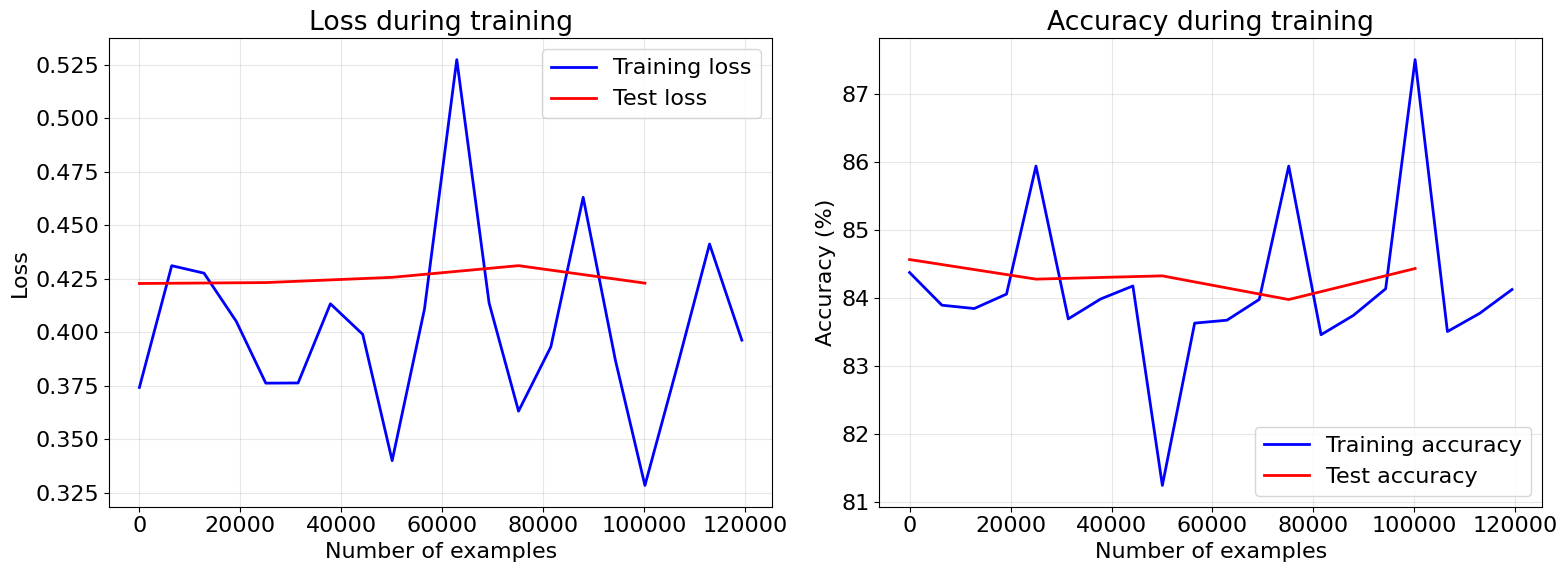

In [44]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.size'] = '16'

# Первый график - Loss
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
plt.plot(train_counter, train_losses, color='blue', linewidth=2)
plt.plot(test_counter, test_losses, color='red', linewidth=2)
plt.legend(['Training loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.grid(True, alpha=0.3)

# Второй график - Accuracy
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
plt.plot(train_counter, train_acc, color='blue', linewidth=2)
plt.plot(test_counter, test_acc, color='red', linewidth=2)
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Чтобы графики не перекрывались
plt.show()

In [45]:
check_quantization_status(qat_model_classifier)
check_by_size_comparison_complete(fp32_model, qat_model_classifier)

visual_features.features.0: Conv2d | dtype: torch.float32 | shape: torch.Size([64, 3, 11, 11])
visual_features.features.3: Conv2d | dtype: torch.float32 | shape: torch.Size([192, 64, 5, 5])
visual_features.features.6: Conv2d | dtype: torch.float32 | shape: torch.Size([384, 192, 3, 3])
visual_features.features.8: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 384, 3, 3])
visual_features.features.10: Conv2d | dtype: torch.float32 | shape: torch.Size([256, 256, 3, 3])
metadata_net.0: Linear | dtype: torch.float32 | shape: torch.Size([64, 3])
metadata_net.3: Linear | dtype: torch.float32 | shape: torch.Size([32, 64])
metadata_net.6: Linear | dtype: torch.float32 | shape: torch.Size([16, 32])
quantized_classifiers.visual_classifier.1: Linear | КВАНТОВАННЫЙ СЛОЙ
quantized_classifiers.visual_classifier.1._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
quantized_classifiers.combined_classifier.0: Linear | КВАНТОВАННЫЙ СЛОЙ
quantized_classifiers.combined_classifier.0._packed_par

(27.708040237426758, 14.023883819580078, 49.386951587296835)

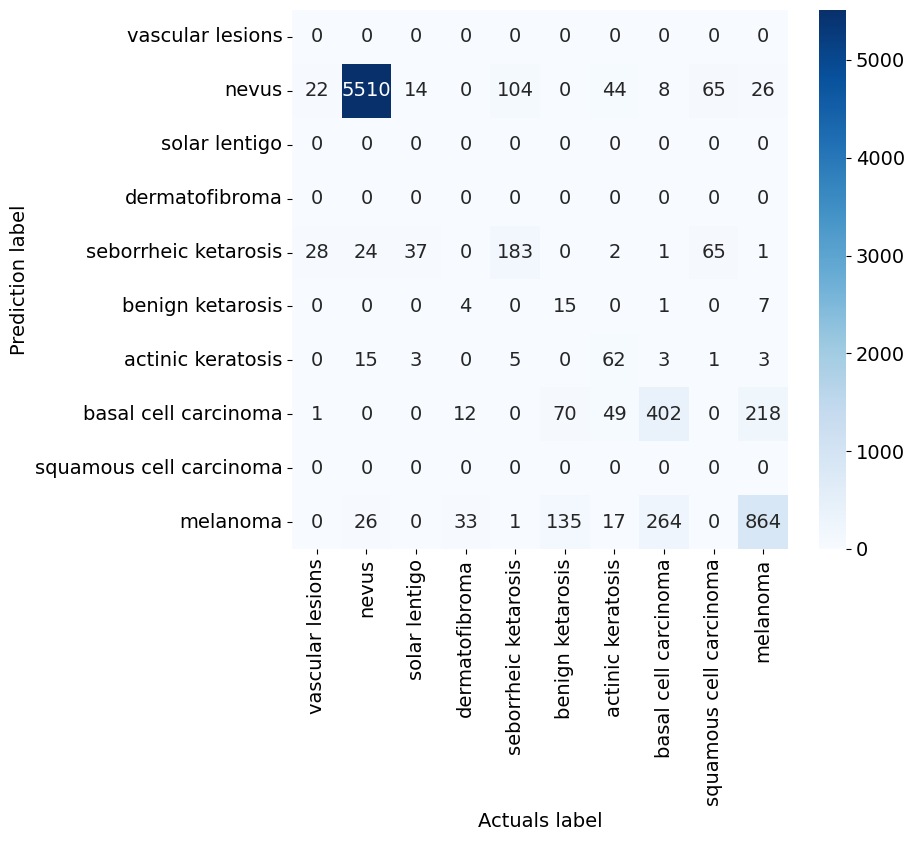

Sensitivity: 0.8431
Specificity: 0.9826
Precision: 0.8431
NPV: 0.9826
PPV: 0.8431
FNR: 0.1569
FPR: 0.0174
F1: 0.8431
Recall micro: 0.8431
Recall macro: 0.3402
Precision micro: 0.8431
Precision macro: 0.3897
F1 score micro: 0.8431
F1 score macro: 0.3399
Jaccard score micro: 0.7288
Jaccard score macro: 0.2647
Accuracy score: 0.8431
Matthews corrcoef: 0.6921
Specificity macro: 0.9762
Specificity micro: 0.9826
Specificity weighted: 0.9184
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.8978
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9804
Specificity none - class benign ketarosis (5): 0.9985
Specificity none - class actinic keratosis (6): 0.9963
Specificity none - class basal cell carcinoma (7): 0.9543
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9341


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(qat_model_classifier, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

qat_accuracy_classifier = test_metric()

In [47]:
class QuantizedMultimodal_QAT(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.visual_features = original_model.visual_features
        self.visual_classifier = original_model.visual_classifier
        self.metadata_net = original_model.metadata_net
        self.combined_classifier = original_model.combined_classifier
        
    def forward(self, image, metadata):
        image = self.quant(image)
        metadata = self.quant(metadata)

        visual_feat = self.visual_features(image)
        visual_feat = visual_feat.view(visual_feat.size(0), -1)
        visual_out = self.visual_classifier(visual_feat)
        
        metadata_out = self.metadata_net(metadata)

        visual_out = self.dequant(visual_out)
        metadata_out = self.dequant(metadata_out)
        
        combined = torch.cat((visual_out, metadata_out), dim=1)

        combined = self.quant(combined)
        output = self.combined_classifier(combined)
        output = self.dequant(output)
        
        return output

def QAT_quantize_completely_simple(model):
    
    quant_model = QuantizedMultimodal_QAT(model)
    quant_model = quant_model.to(device)

    quant_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

    model_prepared = prepare_qat(quant_model, inplace=False)
    
    return model_prepared

device = torch.device("cpu")
fp32_model = fp32_model.to(device)

qat_model_full = Multimodal_NN(num_metadata_features, num_classes).to(device)
qat_model_full.load_state_dict(fp32_model.state_dict())

qat_model_full = QAT_quantize_completely_simple(qat_model_full)

print("Начало QAT с предобученными весами...")
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(qat_model_full.parameters(), lr=0.001, momentum=0.9)
    
num_epochs = 5
    
train_losses = []
train_counter = []
train_acc = []
    
test_losses = []
test_counter = [i*len_trainset for i in range(num_epochs)]
test_acc = []
    
device = torch.device("cuda")
qat_model_full  = train_and_evaluate(qat_model_full, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs, 'qat_model_full')

device = torch.device("cpu")
qat_model_full.eval()
qat_model_full  = qat_model_full.to(device)
qat_model_full = convert(qat_model_full, inplace=False)

print(f"QAT мультимодальная модель qat_model_full на int_8 успешно сконвертирована!")

C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Начало QAT с предобученными весами...
________________________________________________________________________________________________________________________
Эпоха 1/5

Тренировочная эпоха: 1 [0/25035 (0%)]		 | Ошибка: 0.4158	 | Точность распознавания: 82.81%
Тренировочная эпоха: 1 [6400/25035 (26%)]		 | Ошибка: 0.3844	 | Точность распознавания: 83.18%
Тренировочная эпоха: 1 [12800/25035 (51%)]		 | Ошибка: 0.4309	 | Точность распознавания: 83.36%
Тренировочная эпоха: 1 [19200/25035 (77%)]		 | Ошибка: 0.3634	 | Точность распознавания: 83.72%

   Тренировочная ошибка: 0.4316 Точность: 21001/25035 (83.89%)
        Время обучения: 00:00:18

   Валидационная ошибка: 0.4240 Точность: 7060/8345 (84.60%)
        Время тестирования: 00:00:04

Лучшая валидационная точность: 0.8460
________________________________________________________________________________________________________________________
Эпоха 2/5

Тренировочная эпоха: 2 [0/25035 (0%)]		 | Ошибка: 0.3521	 | Точность распознавания: 8

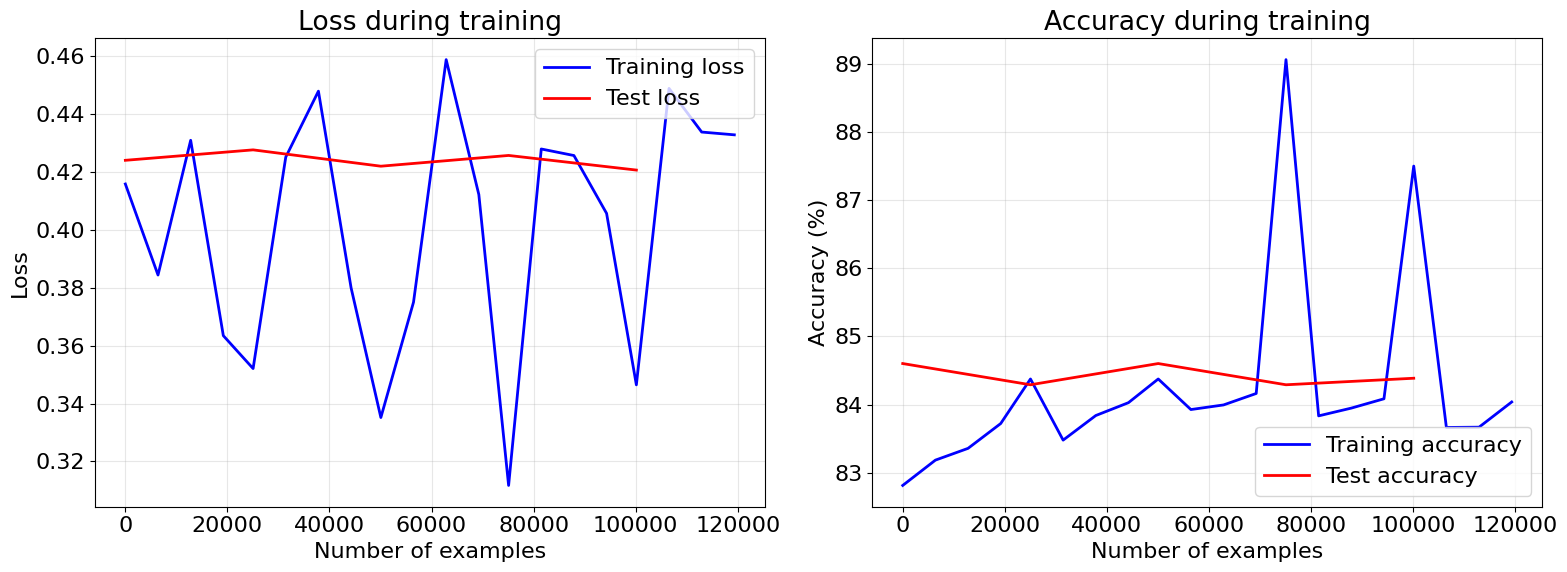

In [48]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.size'] = '16'

# Первый график - Loss
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
plt.plot(train_counter, train_losses, color='blue', linewidth=2)
plt.plot(test_counter, test_losses, color='red', linewidth=2)
plt.legend(['Training loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.grid(True, alpha=0.3)

# Второй график - Accuracy
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
plt.plot(train_counter, train_acc, color='blue', linewidth=2)
plt.plot(test_counter, test_acc, color='red', linewidth=2)
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Чтобы графики не перекрывались
plt.show()

In [49]:
check_quantization_status(qat_model_full)
check_by_size_comparison_complete(fp32_model, qat_model_full)

visual_features.features.0: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.3: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.6: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.8: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_features.features.10: Conv2d | КВАНТОВАННЫЙ СЛОЙ
visual_classifier.1: Linear | КВАНТОВАННЫЙ СЛОЙ
visual_classifier.1._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.0: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.0._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.3: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.3._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
metadata_net.6: Linear | КВАНТОВАННЫЙ СЛОЙ
metadata_net.6._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.0: Linear | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.0._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.3: Linear | КВАНТОВАННЫЙ СЛОЙ
combined_classifier.3._packed_params: LinearPackedParams | КВАНТОВАННЫЙ СЛОЙ
ПОЛНОЕ С

(27.708040237426758, 6.982297897338867, 74.80046283494457)

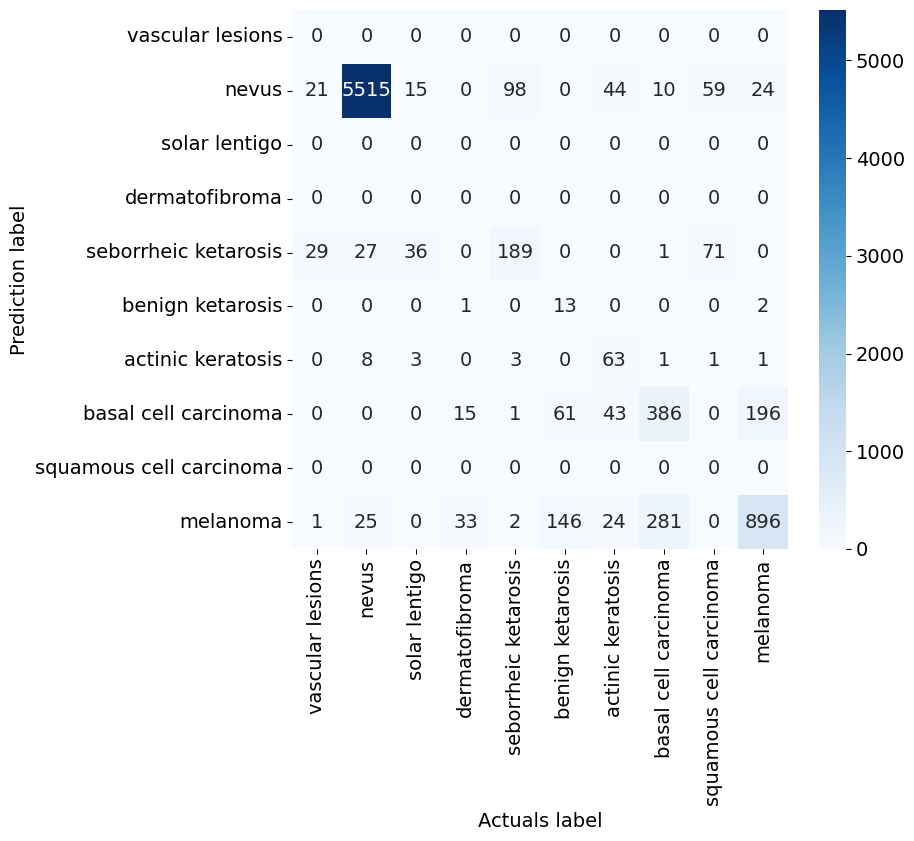

Sensitivity: 0.8463
Specificity: 0.9829
Precision: 0.8463
NPV: 0.9829
PPV: 0.8463
FNR: 0.1537
FPR: 0.0171
F1: 0.8463
Recall micro: 0.8463
Recall macro: 0.3425
Precision micro: 0.8463
Precision macro: 0.4275
F1 score micro: 0.8463
F1 score macro: 0.3430
Jaccard score micro: 0.7335
Jaccard score macro: 0.2682
Accuracy score: 0.8463
Matthews corrcoef: 0.6987
Specificity macro: 0.9767
Specificity micro: 0.9829
Specificity weighted: 0.9210
Specificity none - class vascular lesions (0): 1.0000
Specificity none - class nevus (1): 0.9022
Specificity none - class solar lentigo (2): 1.0000
Specificity none - class dermatofibroma (3): 1.0000
Specificity none - class seborrheic ketarosis (4): 0.9796
Specificity none - class benign ketarosis (5): 0.9996
Specificity none - class actinic keratosis (6): 0.9979
Specificity none - class basal cell carcinoma (7): 0.9588
Specificity none - class squamous cell carcinoma (8): 1.0000
Specificity none - class melanoma (9): 0.9291


C:\Users\Ulyana\anaconda3\envs\NN_3_11_11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
actuals = []
predictions = []

device = torch.device("cpu")
test_NN(qat_model_full, testloader)

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, labels_cat2, labels_cat2)
plt.rcParams['font.size'] = '14'

plt.figure(figsize = (8,7))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Actuals label")
plt.ylabel("Prediction label")
plt.show()

qat_accuracy_full = test_metric()

In [51]:
def find_all_models():
    """Находит все экземпляры nn.Module в глобальной области видимости"""
    import torch.nn as nn
    models = {}
    
    for var_name, var_value in globals().items():
        if isinstance(var_value, nn.Module):
            models[var_name] = {
                'type': type(var_value).__name__,
                #'device': next(var_value.parameters()).device if any(var_value.parameters()) else 'no parameters',
                'parameters': sum(p.numel() for p in var_value.parameters()),
                'size_mb': sum(p.numel() * p.element_size() for p in var_value.parameters()) / (1024 * 1024)
            }
    
    return models

# Использование:
all_models = find_all_models()
print("🎯 НАЙДЕННЫЕ МОДЕЛИ:")
for name, info in all_models.items():
    print(f"  {name}: {info['type']} | Параметров: {info['parameters']:,} | Размер: {info['size_mb']:.2f} МБ")

🎯 НАЙДЕННЫЕ МОДЕЛИ:
  original_NN: AlexNet | Параметров: 61,100,840 | Размер: 233.08 МБ
  _2: AlexNet | Параметров: 61,100,840 | Размер: 233.08 МБ
  fp32_model: Multimodal_NN | Параметров: 7,260,666 | Размер: 27.70 МБ
  criterion: CrossEntropyLoss | Параметров: 0 | Размер: 0.00 МБ
  ptq_model_CNN: Multimodal_NN | Параметров: 4,790,970 | Размер: 18.28 МБ
  ptq_model_model_quantized_CNN: Multimodal_NN | Параметров: 4,790,970 | Размер: 18.28 МБ
  ptq_model_MLP: Multimodal_NN | Параметров: 7,257,802 | Размер: 27.69 МБ
  ptq_model_model_quantized_MLP: Multimodal_NN | Параметров: 7,257,802 | Размер: 27.69 МБ
  ptq_model_linear: Multimodal_NN | Параметров: 7,260,666 | Размер: 27.70 МБ
  ptq_model_model_quantized_linear: Multimodal_With_QuantizedClassifiers | Параметров: 2,472,560 | Размер: 9.43 МБ
  ptq_model_full: Multimodal_NN | Параметров: 7,260,666 | Размер: 27.70 МБ
  ptq_model_model_quantized_full: QuantizedMultimodal | Параметров: 0 | Размер: 0.00 МБ
  qat_model_CNN: Multimodal_NN | Па

In [52]:
print(f"Точность FP32 {model_name}: {fp32_final_acc:.2f}%")
print("_" * 60)

print(f"Точность PTQ_CNN {model_name}: {ptq_accuracy_CNN:.2f}%")
print(f"Точность PTQ_MLP {model_name}: {ptq_accuracy_MLP:.2f}%")
print(f"Точность PTQ_classif {model_name}: {ptq_accuracy_linear:.2f}%")
print(f"Точность PTQ_full {model_name}: {ptq_accuracy_full:.2f}%")
print("_" * 60)

print(f"Точность QAT_CNN {model_name}: {qat_accuracy_CNN:.2f}%")
print(f"Точность QAT_MLP {model_name}: {qat_accuracy_MLP:.2f}%")
print(f"Точность QAT_classif {model_name}: {qat_accuracy_classifier:.2f}%")
print(f"Точность QAT_full {model_name}: {qat_accuracy_full:.2f}%")
print("_" * 60)

#print(f"\nПотеря точности PTQ: {fp32_final_acc - ptq_accuracy_full:.2f}%")
#print(f"Потеря точности QAT: {fp32_final_acc - qat_accuracy_full:.2f}%")

Точность FP32 alexnet: 84.35%
____________________________________________________________
Точность PTQ_CNN alexnet: 84.04%
Точность PTQ_MLP alexnet: 84.35%
Точность PTQ_classif alexnet: 84.31%
Точность PTQ_full alexnet: 84.16%
____________________________________________________________
Точность QAT_CNN alexnet: 84.39%
Точность QAT_MLP alexnet: 84.58%
Точность QAT_classif alexnet: 84.31%
Точность QAT_full alexnet: 84.63%
____________________________________________________________


In [53]:
torch.save(fp32_model.state_dict(), "multimodal_fp32.pth")
fp32_size = os.path.getsize("multimodal_fp32.pth")
print(f"Размер FP32 оригинальной модели: {fp32_size / 1024 / 1024:.2f} MB")
print()

# PTQ модели
print("🎯 PTQ МОДЕЛИ:")
print("-" * 50)

# PTQ AlexNet
torch.save(ptq_model_model_quantized_CNN.state_dict(), "multimodal_ptq_alexnet.pth")
ptq_alexnet_size = os.path.getsize("multimodal_ptq_alexnet.pth")
print(f"PTQ AlexNet: {ptq_alexnet_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / ptq_alexnet_size:.2f}x")

# PTQ MLP
torch.save(ptq_model_model_quantized_MLP.state_dict(), "multimodal_ptq_mlp.pth")
ptq_mlp_size = os.path.getsize("multimodal_ptq_mlp.pth")
print(f"PTQ MLP:     {ptq_mlp_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / ptq_mlp_size:.2f}x")

# PTQ Classifiers
torch.save(ptq_model_model_quantized_linear.state_dict(), "multimodal_ptq_classifiers.pth")
ptq_classifiers_size = os.path.getsize("multimodal_ptq_classifiers.pth")
print(f"PTQ Classifiers: {ptq_classifiers_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / ptq_classifiers_size:.2f}x")

# PTQ Full
torch.save(ptq_model_model_quantized_full.state_dict(), "multimodal_ptq_full.pth")
ptq_full_size = os.path.getsize("multimodal_ptq_full.pth")
print(f"PTQ Full:    {ptq_full_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / ptq_full_size:.2f}x")

print()
print("🎯 QAT МОДЕЛИ:")
print("-" * 50)

# QAT AlexNet
torch.save(qat_model_CNN.state_dict(), "multimodal_qat_alexnet.pth")
qat_alexnet_size = os.path.getsize("multimodal_qat_alexnet.pth")
print(f"QAT AlexNet: {qat_alexnet_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / qat_alexnet_size:.2f}x")

# QAT MLP
torch.save(qat_model_MLP.state_dict(), "multimodal_qat_mlp.pth")
qat_mlp_size = os.path.getsize("multimodal_qat_mlp.pth")
print(f"QAT MLP:     {qat_mlp_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / qat_mlp_size:.2f}x")

# QAT Classifiers
torch.save(qat_model_classifier.state_dict(), "multimodal_qat_classifiers.pth")
qat_classifiers_size = os.path.getsize("multimodal_qat_classifiers.pth")
print(f"QAT Classifiers: {qat_classifiers_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / qat_classifiers_size:.2f}x")

# QAT Full
torch.save(qat_model_full.state_dict(), "multimodal_qat_full.pth")
qat_full_size = os.path.getsize("multimodal_qat_full.pth")
print(f"QAT Full:    {qat_full_size / 1024 / 1024:.2f} MB | Сжатие: {fp32_size / qat_full_size:.2f}x")

Размер FP32 оригинальной модели: 27.71 MB

🎯 PTQ МОДЕЛИ:
--------------------------------------------------
PTQ AlexNet: 20.67 MB | Сжатие: 1.34x
PTQ MLP:     27.70 MB | Сжатие: 1.00x
PTQ Classifiers: 14.02 MB | Сжатие: 1.98x
PTQ Full:    6.98 MB | Сжатие: 3.97x

🎯 QAT МОДЕЛИ:
--------------------------------------------------
QAT AlexNet: 20.67 MB | Сжатие: 1.34x
QAT MLP:     27.70 MB | Сжатие: 1.00x
QAT Classifiers: 14.02 MB | Сжатие: 1.98x
QAT Full:    6.98 MB | Сжатие: 3.97x


In [62]:
def create_comprehensive_report():
    """Создает комплексный отчет по всем моделям"""
    
    # Собираем все данные точности
    accuracy_data = {
        'FP32': fp32_final_acc,
        'PTQ_CNN': ptq_accuracy_CNN,
        'PTQ_MLP': ptq_accuracy_MLP,
        'PTQ_classif': ptq_accuracy_linear,
        'PTQ_full': ptq_accuracy_full,
        'QAT_CNN': qat_accuracy_CNN,
        'QAT_MLP': qat_accuracy_MLP,
        'QAT_classif': qat_accuracy_classifier,
        'QAT_full': qat_accuracy_full
    }
    
    # Получаем размеры моделей
    size_data = get_model_sizes()
    
    # Получаем данные скорости
    speed_data = get_model_speeds()
    
    # Создаем визуализацию
    create_comprehensive_visualization(accuracy_data, size_data, speed_data)
    
    return accuracy_data, size_data, speed_data

def get_model_sizes():
    """Получает размеры всех моделей"""
    models = {
        'FP32': fp32_model,
        'PTQ_CNN': ptq_model_model_quantized_CNN,
        'PTQ_MLP': ptq_model_model_quantized_MLP,
        'PTQ_classif': ptq_model_model_quantized_linear,
        'PTQ_full': ptq_model_model_quantized_full,
        'QAT_CNN': qat_model_CNN,
        'QAT_MLP': qat_model_MLP,
        'QAT_classif': qat_model_classifier,
        'QAT_full': qat_model_full
    }
    
    sizes = {}
    for name, model in models.items():
        torch.save(model.state_dict(), f"temp_{name}.pth")
        size_bytes = os.path.getsize(f"temp_{name}.pth")
        sizes[name] = size_bytes / 1024 / 1024  # Convert to MB
        os.remove(f"temp_{name}.pth")
    
    return sizes

def get_model_speeds():
    """Получает данные о скорости всех моделей"""
    # Запускаем бенчмарки если еще не сделано
    fp32_avg, ptq_results, qat_results = run_all_benchmarks()
    
    speeds = {'FP32': 1.0}  # Базовое значение
    
    # PTQ скорости
    for name, (total, avg) in ptq_results.items():
        speeds[f'PTQ_{name}'] = fp32_avg / avg
    
    # QAT скорости
    for name, (total, avg) in qat_results.items():
        speeds[f'QAT_{name}'] = fp32_avg / avg
    
    return speeds

def benchmark_model(model, test_loader, model_name, num_batches=20):
    device = torch.device("cpu")
    model = model.to(device).eval()
    
    # Теплый запуск
    with torch.no_grad():
        for inputs, feats, label, name in test_loader:
            inputs = inputs.to(device)
            feats = feats.to(device)
            _ = model(inputs, feats)
            break
    
    # Бенчмарк
    start_time = time.time()
    with torch.no_grad():
        for i, (inputs, feats, label, name) in enumerate(test_loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            feats = feats.to(device)
            _ = model(inputs, feats)
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_batches
    return total_time, avg_time_per_batch

def run_all_benchmarks():
    """Запускает бенчмарки для всех моделей"""
    
    print("🚀 ЗАПУСК БЕНЧМАРКОВ ВСЕХ МОДЕЛЕЙ")
    print("_" * 70)
    
    # Бенчмарк FP32 модели
    print("🔵 Бенчмарк FP32 оригинальной модели...")
    fp32_total, fp32_avg = benchmark_model(fp32_model, testloader, "FP32 Original")
    
    # PTQ модели
    print("\n🎯 PTQ МОДЕЛИ:")
    print("-" * 50)
    
    ptq_results = {}
    
    print("Бенчмарк PTQ AlexNet...")
    ptq_alexnet_total, ptq_alexnet_avg = benchmark_model(ptq_model_model_quantized_CNN, testloader, "PTQ AlexNet")
    ptq_results['alexnet'] = (ptq_alexnet_total, ptq_alexnet_avg)
    
    print("Бенчмарк PTQ MLP...")
    ptq_mlp_total, ptq_mlp_avg = benchmark_model(ptq_model_model_quantized_MLP, testloader, "PTQ MLP")
    ptq_results['mlp'] = (ptq_mlp_total, ptq_mlp_avg)
    
    print("Бенчмарк PTQ Classifiers...")
    ptq_classifiers_total, ptq_classifiers_avg = benchmark_model(ptq_model_model_quantized_linear, testloader, "PTQ Classifiers")
    ptq_results['classifiers'] = (ptq_classifiers_total, ptq_classifiers_avg)
    
    print("Бенчмарк PTQ Full...")
    ptq_full_total, ptq_full_avg = benchmark_model(ptq_model_model_quantized_full, testloader, "PTQ Full")
    ptq_results['full'] = (ptq_full_total, ptq_full_avg)
    
    # QAT модели
    print("\n🎯 QAT МОДЕЛИ:")
    print("-" * 50)
    
    qat_results = {}
    
    print("Бенчмарк QAT AlexNet...")
    qat_alexnet_total, qat_alexnet_avg = benchmark_model(qat_model_CNN, testloader, "QAT AlexNet")
    qat_results['alexnet'] = (qat_alexnet_total, qat_alexnet_avg)
    
    print("Бенчмарк QAT MLP...")
    qat_mlp_total, qat_mlp_avg = benchmark_model(qat_model_MLP, testloader, "QAT MLP")
    qat_results['mlp'] = (qat_mlp_total, qat_mlp_avg)
    
    print("Бенчмарк QAT Classifiers...")
    qat_classifiers_total, qat_classifiers_avg = benchmark_model(qat_model_classifier, testloader, "QAT Classifiers")
    qat_results['classifiers'] = (qat_classifiers_total, qat_classifiers_avg)
    
    print("Бенчмарк QAT Full...")
    qat_full_total, qat_full_avg = benchmark_model(qat_model_full, testloader, "QAT Full")
    qat_results['full'] = (qat_full_total, qat_full_avg)
    
    # Вывод результатов
    print_results(fp32_avg, ptq_results, qat_results)
    
    return fp32_avg, ptq_results, qat_results

def print_results(fp32_avg, ptq_results, qat_results):
    """Красивый вывод результатов"""
    
    print("\n" + "_" * 80)
    print("📊 РЕЗУЛЬТАТЫ СКОРОСТИ (CPU)")
    print("_" * 80)
    print(f"{'Модель':<25} {'Время батча':<12} {'Ускорение':<10} {'Статус':<15}")
    print("-" * 80)
    
    print(f"{'FP32 Original':<25} {fp32_avg:>8.4f}s    {'-':<10}    {'Базовый':<15}")
    
    # PTQ результаты
    for name, (total, avg) in ptq_results.items():
        speedup = fp32_avg / avg
        status = "🚀 ОТЛИЧНО" if speedup > 1.5 else "✅ ХОРОШО" if speedup > 1.1 else "⚠️ НОРМА"
        print(f"{'PTQ ' + name.capitalize():<25} {avg:>8.4f}s    {speedup:>7.2f}x    {status:<15}")
    
    # QAT результаты  
    for name, (total, avg) in qat_results.items():
        speedup = fp32_avg / avg
        status = "🚀 ОТЛИЧНО" if speedup > 1.5 else "✅ ХОРОШО" if speedup > 1.1 else "⚠️ НОРМА"
        print(f"{'QAT ' + name.capitalize():<25} {avg:>8.4f}s    {speedup:>7.2f}x    {status:<15}")
    
    print("=" * 80)
    
    # Находим лучшие модели
    best_ptq = max(ptq_results.items(), key=lambda x: fp32_avg / x[1][1])
    best_qat = max(qat_results.items(), key=lambda x: fp32_avg / x[1][1])
    
    print(f"\n🏆 Лучшее PTQ ускорение: {best_ptq[0]} - {fp32_avg / best_ptq[1][1]:.2f}x")
    print(f"🏆 Лучшее QAT ускорение: {best_qat[0]} - {fp32_avg / best_qat[1][1]:.2f}x")

In [63]:
def create_comprehensive_visualization(accuracy_data, size_data, speed_data):
    
    # Подготовка данных
    models = list(accuracy_data.keys())
    accuracies = list(accuracy_data.values())
    sizes = [size_data.get(model, 0) for model in models]
    speeds = [speed_data.get(model, 1.0) for model in models]
    
    # Цвета для разных типов моделей
    colors = []
    for model in models:
        if model == 'FP32':
            colors.append('blue')
        elif model.startswith('PTQ'):
            colors.append('red')
        else:  # QAT
            colors.append('green')
    
    # Создаем графики
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    plt.rcParams['font.size'] = 12
    
    # 1. График точности
    bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.8)
    ax1.set_title('Сравнение точности всех моделей', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Точность (%)', fontsize=14)
    ax1.set_ylim(0, max(accuracies) + 5)
    ax1.tick_params(axis='x', rotation=45)
    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 2. График размеров
    bars2 = ax2.bar(models, sizes, color=colors, alpha=0.8)
    ax2.set_title('Сравнение размеров моделей', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Размер (MB)', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    for bar, size in zip(bars2, sizes):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{size:.2f}MB', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 3. График скорости
    bars3 = ax3.bar(models, speeds, color=colors, alpha=0.8)
    ax3.set_title('Относительная скорость моделей', fontsize=16, fontweight='bold')
    ax3.set_ylabel('Ускорение (x)', fontsize=14)
    ax3.tick_params(axis='x', rotation=45)
    for bar, speed in zip(bars3, speeds):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{speed:.2f}x', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 4. Сводная таблица
    ax4.axis('tight')
    ax4.axis('off')
    
    # Подготовка данных для таблицы
    table_data = []
    for model in models:
        table_data.append([
            f"{accuracy_data.get(model, 0):.2f}%",
            f"{size_data.get(model, 0):.1f} MB",
            f"{speed_data.get(model, 1.0):.2f}x"
        ])
    
    table = ax4.table(
        cellText=table_data,
        rowLabels=models,
        colLabels=['Точность', 'Размер', 'Ускорение'],
        cellLoc='center',
        loc='center',
        colWidths=[0.3, 0.3, 0.3]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax4.set_title('Сводная таблица всех моделей', fontsize=16, fontweight='bold')
    
    # Легенда
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor='blue', alpha=0.8, label='FP32'),
        plt.Rectangle((0,0), 1, 1, facecolor='red', alpha=0.8, label='PTQ'),
        plt.Rectangle((0,0), 1, 1, facecolor='green', alpha=0.8, label='QAT')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
               ncol=3, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # Вывод статистики
    print_statistics(accuracy_data, size_data, speed_data)

In [64]:
def print_statistics(accuracy_data, size_data, speed_data):
    """Выводит статистику по всем моделям"""
    
    print("_" * 80)
    print("📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ МОДЕЛЕЙ")
    print("_" * 80)
    
    # Лучшие модели по каждому показателю
    best_accuracy = max(accuracy_data.items(), key=lambda x: x[1])
    best_compression = max(size_data.items(), key=lambda x: size_data['FP32'] / x[1])
    best_speed = max(speed_data.items(), key=lambda x: x[1])
    
    print(f"🏆 Лучшая точность: {best_accuracy[0]} - {best_accuracy[1]:.2f}%")
    print(f"🏆 Лучшее сжатие: {best_compression[0]} - {size_data['FP32']/best_compression[1]:.2f}x")
    print(f"🏆 Лучшая скорость: {best_speed[0]} - {best_speed[1]:.2f}x")
    print()
    
    # Сравнение PTQ vs QAT
    ptq_models = {k: v for k, v in accuracy_data.items() if k.startswith('PTQ')}
    qat_models = {k: v for k, v in accuracy_data.items() if k.startswith('QAT')}
    
    if ptq_models and qat_models:
        avg_ptq_accuracy = sum(ptq_models.values()) / len(ptq_models)
        avg_qat_accuracy = sum(qat_models.values()) / len(qat_models)
        
        print("📈 СРЕДНИЕ ПОКАЗАТЕЛИ:")
        print(f"  PTQ модели: {avg_ptq_accuracy:.2f}% точность")
        print(f"  QAT модели: {avg_qat_accuracy:.2f}% точность")
        
        if avg_qat_accuracy > avg_ptq_accuracy:
            print(f"  ✅ QAT показывает лучшую среднюю точность на {avg_qat_accuracy - avg_ptq_accuracy:.2f}%")
        else:
            print(f"  ⚠️ PTQ показывает лучшую среднюю точность на {avg_ptq_accuracy - avg_qat_accuracy:.2f}%")
    
    print("\n🎯 РЕКОМЕНДАЦИИ:")
    
    # Рекомендации на основе данных
    if accuracy_data.get('PTQ_full', 0) > 95 and speed_data.get('PTQ_full', 0) > 1.5:
        print("  ✅ PTQ Full - оптимальный выбор: высокая точность и скорость")
    elif accuracy_data.get('QAT_full', 0) > accuracy_data.get('PTQ_full', 0):
        print("  ✅ QAT Full - лучшая точность при полном квантовании")
    else:
        print("  ✅ PTQ Full - лучший баланс точности и производительности")
    
    if size_data['FP32'] / size_data.get('PTQ_full', 1) > 3.5:
        print("  ✅ Отличное сжатие моделей (более 3.5x)")

🎯 КОМПЛЕКСНЫЙ ОТЧЕТ ПО ВСЕМ МОДЕЛЯМ
____________________________________________________________
Точность FP32: 84.35%
____________________________________________________________
Точность PTQ_CNN: 84.04%
Точность PTQ_MLP: 84.35%
Точность PTQ_classif: 84.31%
Точность PTQ_full: 84.16%
____________________________________________________________
Точность QAT_CNN: 84.39%
Точность QAT_MLP: 84.58%
Точность QAT_classif: 84.31%
Точность QAT_full: 84.63%
____________________________________________________________
🚀 ЗАПУСК БЕНЧМАРКОВ ВСЕХ МОДЕЛЕЙ
______________________________________________________________________
🔵 Бенчмарк FP32 оригинальной модели...

🎯 PTQ МОДЕЛИ:
--------------------------------------------------
Бенчмарк PTQ AlexNet...
Бенчмарк PTQ MLP...
Бенчмарк PTQ Classifiers...
Бенчмарк PTQ Full...

🎯 QAT МОДЕЛИ:
--------------------------------------------------
Бенчмарк QAT AlexNet...
Бенчмарк QAT MLP...
Бенчмарк QAT Classifiers...
Бенчмарк QAT Full...

__________________________

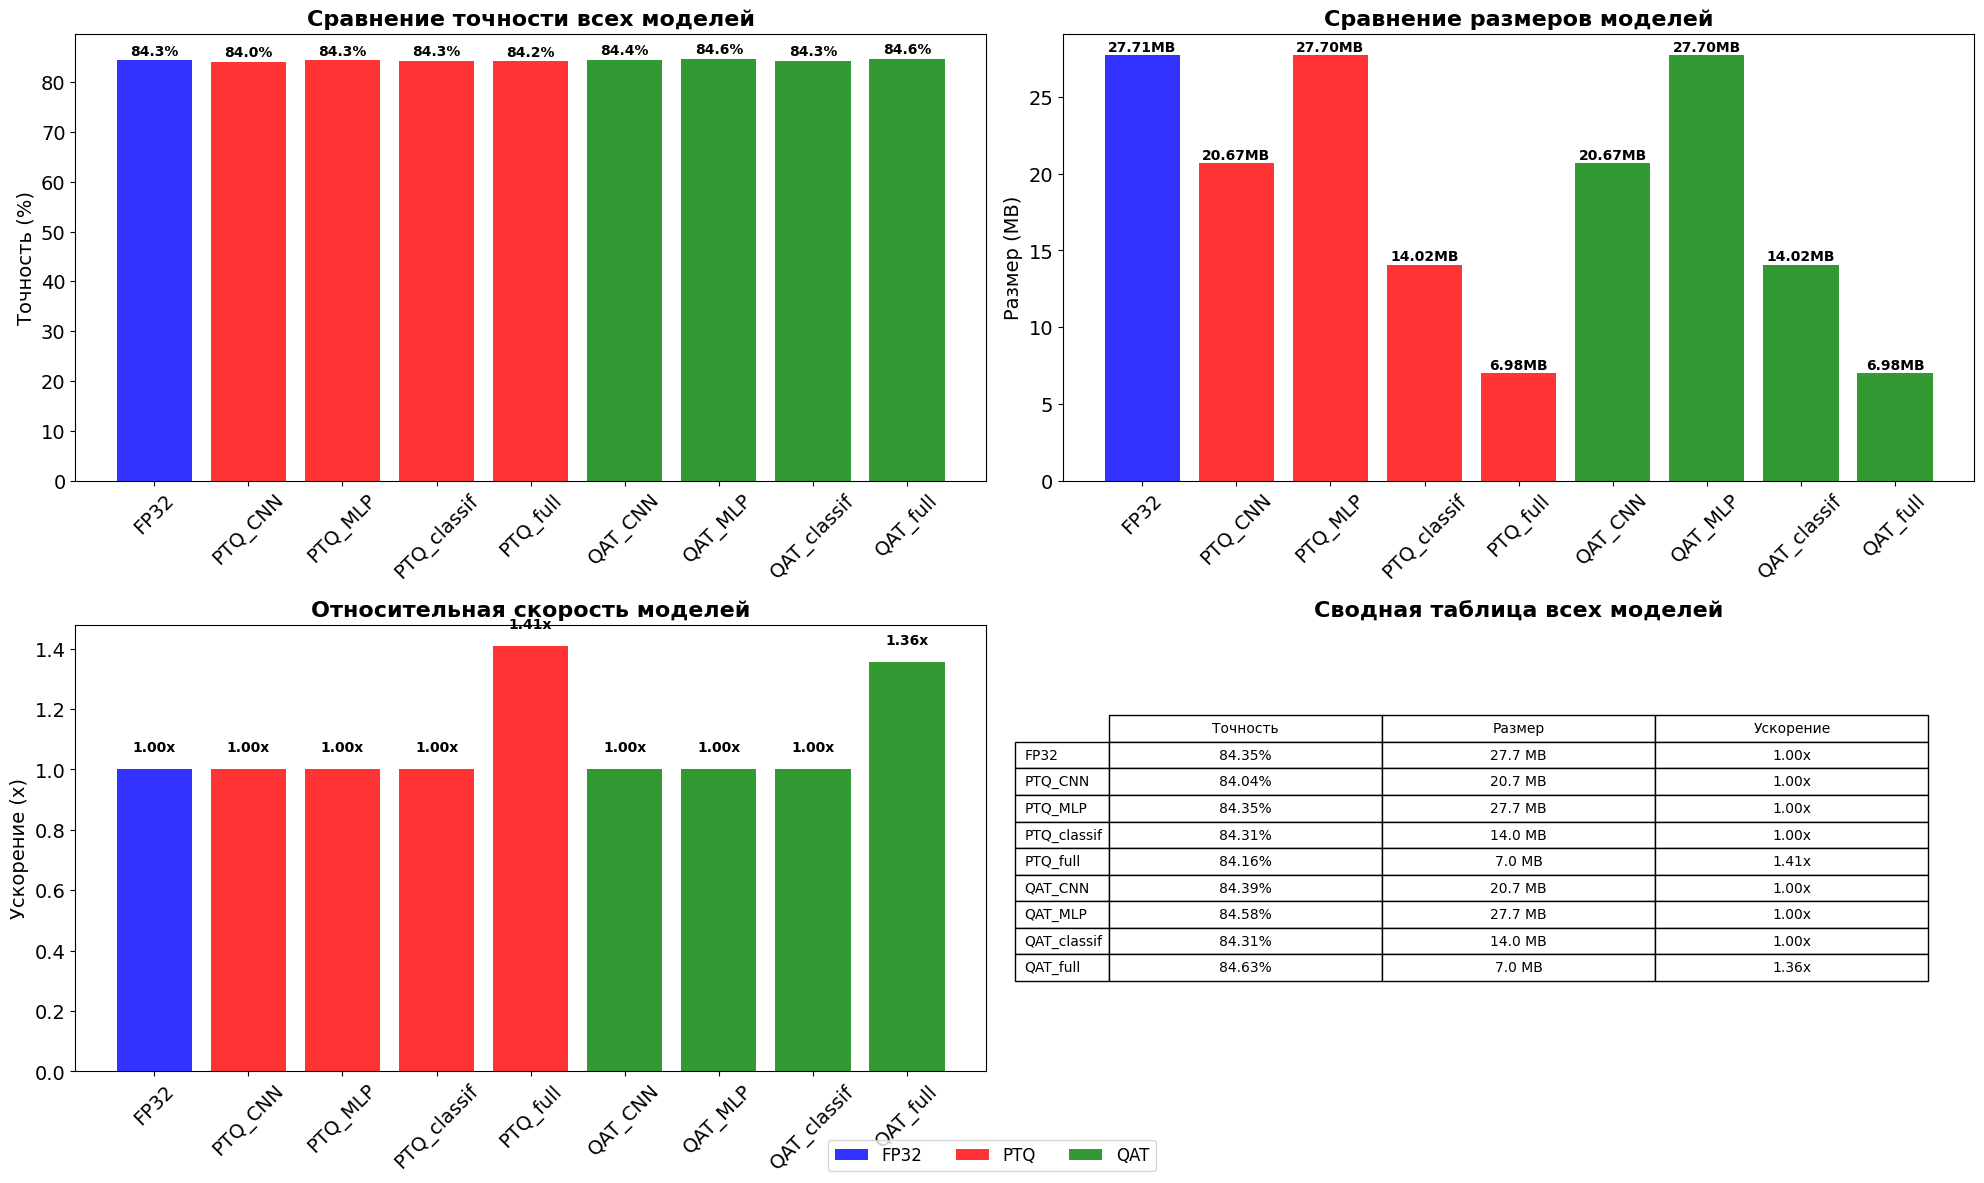

________________________________________________________________________________
📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ МОДЕЛЕЙ
________________________________________________________________________________
🏆 Лучшая точность: QAT_full - 84.63%
🏆 Лучшее сжатие: PTQ_full - 3.97x
🏆 Лучшая скорость: PTQ_full - 1.41x

📈 СРЕДНИЕ ПОКАЗАТЕЛИ:
  PTQ модели: 84.22% точность
  QAT модели: 84.48% точность
  ✅ QAT показывает лучшую среднюю точность на 0.26%

🎯 РЕКОМЕНДАЦИИ:
  ✅ QAT Full - лучшая точность при полном квантовании
  ✅ Отличное сжатие моделей (более 3.5x)


In [65]:
# Запускаем полный отчет
print("🎯 КОМПЛЕКСНЫЙ ОТЧЕТ ПО ВСЕМ МОДЕЛЯМ")
print("_" * 60)

# Выводим исходные данные точности
print(f"Точность FP32: {fp32_final_acc:.2f}%")
print("_" * 60)

print(f"Точность PTQ_CNN: {ptq_accuracy_CNN:.2f}%")
print(f"Точность PTQ_MLP: {ptq_accuracy_MLP:.2f}%")
print(f"Точность PTQ_classif: {ptq_accuracy_linear:.2f}%")
print(f"Точность PTQ_full: {ptq_accuracy_full:.2f}%")
print("_" * 60)

print(f"Точность QAT_CNN: {qat_accuracy_CNN:.2f}%")
print(f"Точность QAT_MLP: {qat_accuracy_MLP:.2f}%")
print(f"Точность QAT_classif: {qat_accuracy_classifier:.2f}%")
print(f"Точность QAT_full: {qat_accuracy_full:.2f}%")
print("_" * 60)

# Создаем визуализацию
accuracy_data, size_data, speed_data = create_comprehensive_report()